# Main ideas

This notebook brings some predictions related to INPE's data about the fire events in Brazil,
[here](http://queimadas.dgi.inpe.br/queimadas/bdqueimadas). 

At first, I have two main plans for this notebook:

Firstly, I plan to make a time series forecasting concerning the burning events.

### A brief digression about the possible solutions

By what we have already investigated, we observe that for most biomes we have during
the first months of the year a high precipitation rate, where the humidity is pretty high
(Season I). After these beginning months, it enters the dry season, where the preciptation
is majoritly very low and, consequently, the humidity as well. During the last month
of this season, it is starts the *burning season*, where the fire events start occurring
in a big scale (Season II). Then, within the last two-theee months of the year the precipitation
starts increasing again, the burning events starts decreasing. This *pattern* happens every
year for most of the biomes. Therefore we observe a seasonal pattern across the years and
we are motivated to use a forecasting model (or a ML algorithm) which encompass this feature
of our data.

For the forecasting model there are several options. We could remove the
seasonality of our data and make use of [ARIMA models](https://otexts.com/fpp2/arima.html)
(for a brief introduction check [wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)). However, since we already know beforehand
that we have this seasonality involved, we can make use of the Seasonal ARIMA model (SARIMA).
There are also possibilities like the [Holt-Winters seasonal method](https://otexts.com/fpp2/holt-winters.html).
To what concerns the latter it makes an exponential smoothing of the past weights, *i.e.,*
the weights decay exponentially as the observations get older.


We could make use of some shift techniques (based on the seasonality of our data) to
make it suitable for a ML application, where the original data corresponds to the *features*
and the shift data corresponds to the *targets*. For the ML algorithm we could use a
[random forest model for forecasting](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/), for example.

The second part of this work is to take the forecasting and turn it into a more appealing plot
(similar to what have we have done).

A possible extension of this work (for sake of curiosity) would be to compare
the ML models and the classical statistical prediction.


# Data treatment strategy

Since we are going to basically take several dataframes and stack on top of each other
for several years, we can speed up the process if we choose it wisely. For doing so,
we only consider the *risco-fogo* column and where it indeed occurred, *df['risco-fogo']==1*.
However, since we are going to analyse it for several years, we can *blur* the data
in a small scale and make a biweekly analysis (or weekly analysis). Since the fire
events last for approximately 3 months.

Let's start by analyzing the data for 2020.To gather the procedure and then generalize it
for all the years.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from datetime import datetime

from sklearn.metrics import mean_squared_error

In [5]:
df2020 = pd.read_csv('../../dataset/data2020.csv', index_col = 'datahora',
                     usecols = ['riscofogo', 'satelite', 'datahora', 'precipitacao', 'latitude', 'longitude'],
                     parse_dates = True)

df2020.head()

,satelite,precipitacao,riscofogo,latitude,longitude
datahora,,,,,
2020-02-19 16:04:41,GOES-16,0.1,1.0,-7.38,-36.06
2020-02-19 16:04:41,GOES-16,0.2,1.0,-7.40,-36.00
2020-02-19 16:04:41,GOES-16,0.2,1.0,-7.38,-36.00
2020-02-20 16:35:55,GOES-16,0.0,1.0,3.89,-60.23
2020-02-20 16:35:55,GOES-16,0.0,1.0,3.87,-60.23


In [3]:
df2020 = df2020[df2020.riscofogo == 1][['latitude', 'longitude', 'riscofogo', 'bioma']].sort_index()

df2020.head()

,latitude,longitude,riscofogo,bioma
datahora,,,,
2020-01-01 00:45:46,-22.8722,-43.7360,1.0,Mata Atlantica
2020-01-01 00:45:47,-22.8624,-43.7386,1.0,Mata Atlantica
2020-01-01 00:45:54,-22.4738,-44.1189,1.0,Mata Atlantica
2020-01-01 00:46:37,-19.4340,-42.5382,1.0,Mata Atlantica
2020-01-01 03:27:57,-22.7764,-42.9099,1.0,Mata Atlantica


In [71]:
## Groupby biome biweekly

df_2020_biweekly = df2020.resample('SM')['riscofogo'].sum().sort_index()

In [70]:
df_2020_biweekly

datahora
2019-12-31      3477.0
2020-01-15      5435.0
2020-01-31      5256.0
2020-02-15      4256.0
2020-02-29      8573.0
2020-03-15      3550.0
2020-03-31      2874.0
2020-04-15      8256.0
2020-04-30      5420.0
2020-05-15      6545.0
2020-05-31     13884.0
2020-06-15     32359.0
2020-06-30     42126.0
2020-07-15     88022.0
2020-07-31    241910.0
2020-08-15    401576.0
2020-08-31    848327.0
2020-09-15    391454.0
2020-09-30    431737.0
2020-10-15    137467.0
2020-10-31     36744.0
2020-11-15     22783.0
Freq: SM-15, Name: riscofogo, dtype: float64

<AxesSubplot:xlabel='datahora'>

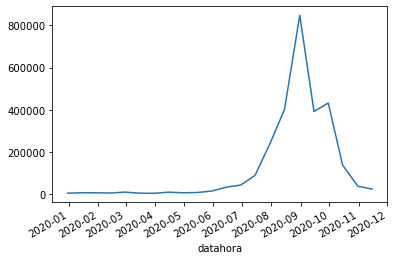

In [6]:
df_2020_biweekly.plot()

And by the plot above we obser the trend already discussed extensively
therein the other notebooks.

Okay, so these commands do what we need to be done to simplify the data. Now let's
implementing it for several years and write a new csv file containing only these information
to make some statistical analysis and afterwards the forecasting.

In [12]:
names = ['data2014', 'data2015', 'data2016', 'data2017', 'data2018', 'data2019', 'data2020']

for name in names:
    df = pd.read_csv('../../dataset/{}.csv'.format(name), index_col = 'datahora',
                     usecols = ['riscofogo', 'satelite', 'datahora', 'precipitacao', 'latitude', 'longitude'],
                     parse_dates = True)
    #df = df[(df.satelite == 'AQUA_M-T') | (df.satelite == 'AQUA_M-M') |
    #                     (df.satelite == 'TERRA_M-T') | (df.satelite == 'TERRA_M-M')]
    #df.drop(columns = ['satelite'], inplace = True)
    
    df = df[df.riscofogo == 1]
    df_biweekly = df.resample('SM')['riscofogo'].sum().sort_index()
    df_biweekly.to_csv('../../sm-dataset/{}_biweekly.csv'.format(name))

Accordingly to *Validação de focos de queimadas no Cerrado emimagens TM/Landsat-5*
by S. C. de Jesus, A. W. Setzer and F. Morelli, researchers from INPE have developed
an algorithm implemented in the data acquisition from satellites *AQUA* and *TERRA*
in an attempt to minimize the mislabeling of focus fire. Therefore we will use these
data. (Okay, there is almost no data avaiable for 2015. Actually some news mention
that in 2015 occurred roughly 25% more fire events than in 2014. Therefore we include
the data from all satelites to make the prediction)

In [16]:
df2014 = pd.read_csv('../../sm-dataset/data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../sm-dataset/data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../sm-dataset/data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../sm-dataset/data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../sm-dataset/data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2019 = pd.read_csv('../../sm-dataset/data2019_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2020 = pd.read_csv('../../sm-dataset/data2020_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2014, df2015, df2016, df2017, df2018, df2019, df2020]).sort_index()

## Since there are duplicated indexes we need to sum them up

df_all = df_all.groupby(df_all.index).sum()

## Handling future *frequency warnings*

df_all = df_all.asfreq('SM')

df_all.index

DatetimeIndex(['2013-12-31', '2014-01-15', '2014-01-31', '2014-02-15',
               '2014-02-28', '2014-03-15', '2014-03-31', '2014-04-15',
               '2014-04-30', '2014-05-15',
               ...
               '2020-06-30', '2020-07-15', '2020-07-31', '2020-08-15',
               '2020-08-31', '2020-09-15', '2020-09-30', '2020-10-15',
               '2020-10-31', '2020-11-15'],
              dtype='datetime64[ns]', name='datahora', length=166, freq='SM-15')

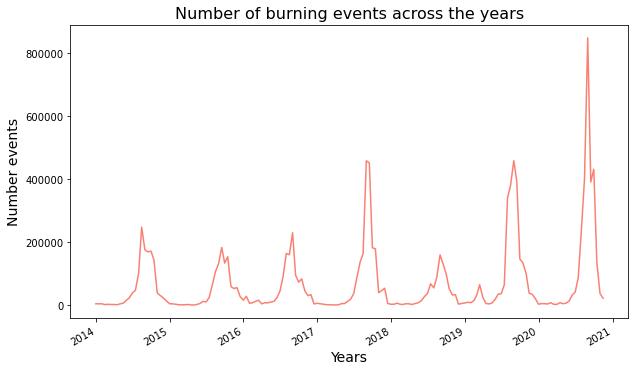

In [17]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_ylabel('Number events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)
ax.set_title('Number of burning events across the years', fontsize = 16)
plt.gcf().autofmt_xdate()

ax.plot(df_all.riscofogo, color = 'salmon')

plt.show()

## Discussing the results

It is worthwhile highlighting that we have an increasing of the burning events from
2016 to 2017, but this number to less than half in 2018 (when compared to the latter).
However, in 2019, we a huge increment in 2019 when compared to 2018. Although
the biggest peak is roughly the same as in 2017, it has a non-negligiable
number of events at the beginning of the year (which is very unexpected,
since we know the humidity during this season is very high throughout
most of the country). Another point which really caughts our eyes is the enourmous
increament in 2020.

One would need to confirm that there is not images from different satelites
from the same part, however, if the number/frequency of image acquisition
hasn't change throughout the past years. If it hasn't this analysis is most
likely correct.

## Statistical analysis

As we have pointed out, we have a seasonal behavior throughout the years and
we also observe that there is a treand related to the increament throughout
the years. To make use of an ARIMA model rightway one would need to remove 
the seasonality (for example, by analyzing the differences between years
instead of the years themselves).

## Next steps

Within the next steps we are going to quantify better what we have described
above. Afterwards we are going to make use of the SARIMA model for making
the prediction for the next year. We start by making use of the
(A)ugmented (D)ickey-Fuller test, [adfuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), which is a class from [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller#statsmodels.tsa.stattools.adfuller).
The null hypothesis is that it is a *non-stationary* process and the alternativa hypothesis
is that it is *stationary* process.

In [21]:
from statsmodels.tsa.stattools import adfuller

# H0: non-stationary
# H1: stationary

adfuller(df_all.riscofogo, autolag = None, maxlag = 23)

(-1.6414038352166171,
 0.46152734250588123,
 23,
 142,
 {'1%': -3.477261624048995,
  '5%': -2.8821181874544233,
  '10%': -2.5777431104939494})

where the first number is value associated to the ADF test made.
The second one is the p-test result and the last one are the critical
values to be compared to the first one. As we can check, we accept the
null hypothesis (our data is non-stationary). To make it is stationary
we have to get rid of the seasonal effects. That can be done by performing
a differencing. We then create a new column for our dataframe. Furthermore,
we also need to check whether there are a trend or not associated to this data.

In [23]:
## Since we have 12 months and we are taking a biweekly data (every two weeks)

df_all['seasonal_diff'] = df_all.riscofogo - df_all.riscofogo.shift(24)

df_all.head()

,riscofogo,seasonal_diff
datahora,,
2013-12-31,723.0,NaN
2014-01-15,713.0,NaN
2014-01-31,630.0,NaN
2014-02-15,354.0,NaN
2014-02-28,524.0,NaN


In [24]:
adfuller(df_all.seasonal_diff.dropna(), autolag = None, maxlag = 23)

(-4.117525605182018,
 0.0009059000854052959,
 23,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913})

Nice, getting rid of the seasonal effects we obtain a stationary data.
Also, we one also observes graphically, there is no trend associated to it.

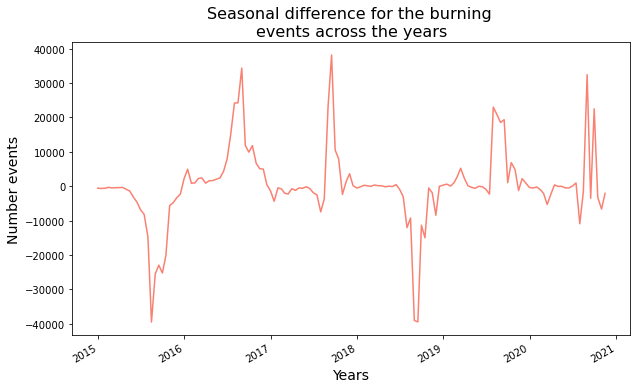

In [25]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_ylabel('Number events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)
ax.set_title('Seasonal difference for the burning \nevents across the years', fontsize = 16)
plt.gcf().autofmt_xdate()

ax.plot(df_all.seasonal_diff, color = 'salmon')

plt.show()

## Investigation about the number of past events needed

Now that it is set to an stationary form, we need to investigate the number
of past events needed for the prediction of an event at a given moment $t$.
That is done by investigating the auto correlation function, that is, how the
function itself is correlated to its previous values in time. That allows us
to know the number of events needed for the prediction. To do so, we use the 
*plot_acf* (plot autocorrelation function) and the *plot_pacf* (p for partial) classes.

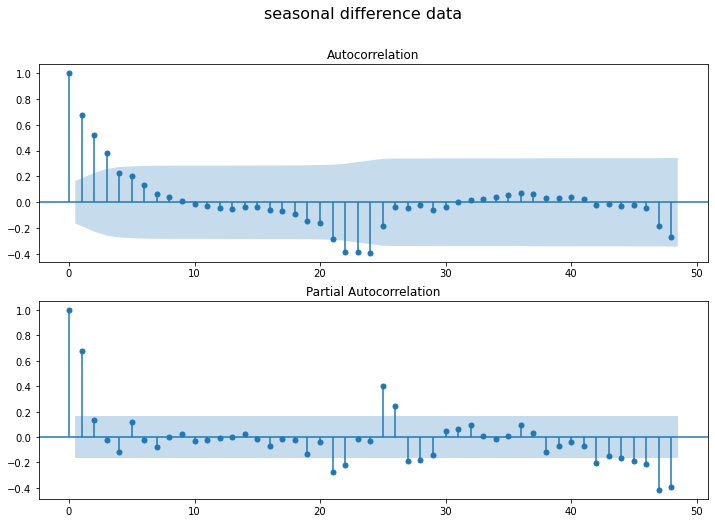

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## For the *seasonal_diff* data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.seasonal_diff.dropna(),lags=48,ax=ax1)
plot_pacf(df_all.seasonal_diff.dropna(),lags=48,ax=ax2)

fig.suptitle('seasonal difference data', fontsize=16)
plt.show()

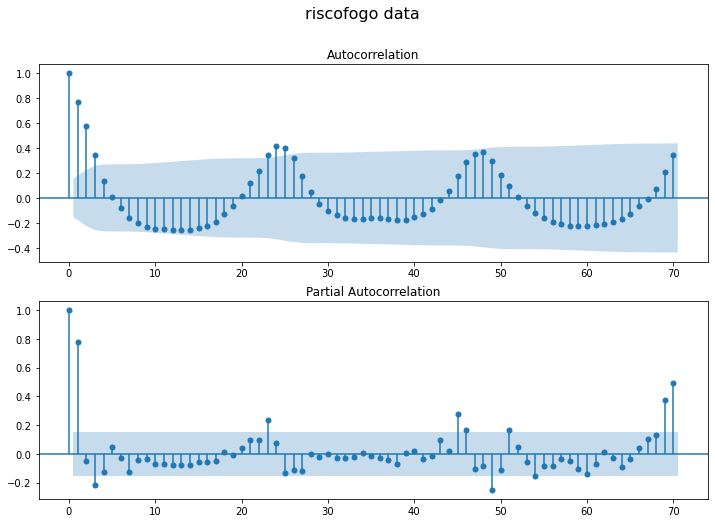

In [29]:
## For the *riscofogo* data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.riscofogo.dropna(),lags=70,ax=ax1)
plot_pacf(df_all.riscofogo.dropna(),lags=70,ax=ax2)

fig.suptitle('riscofogo data', fontsize=16)

plt.show()

The ARIMA model is defined by three quantities p, d, q.

> p corresponds to the information of the PACF

> d corresponds to the differencing process

> q corresponds to the ACF result

The ACF and PACF plots help us to have a better understanding of the relevant information
of our problem. Therein the ACF plot we observe a decaying pattern along the time, that is
a hint that we are dealing with an auto regressive process, *i.e.,* we can make inferences
based on previous data. We observe that there is a seasonal effect where the statistical significant
information is the previous year to the one analyzed (24 lags (semi month)). 

The PCFA helps us to understand the relevant lags to be included and it is apparently $p = (1, 3)$.
The q values are probably $q = (1, 2, 3)$. There is also the seasonal effect which have
to be take into account.

P.S.: It is also important to keep in mind that since our autocorrelation is of order 3, we can
predict at most three months in advance.

In [30]:
y_train = df_all[:len(df_all)-22]
y_test = df_all[len(df_all)-22:]

<AxesSubplot:xlabel='datahora'>

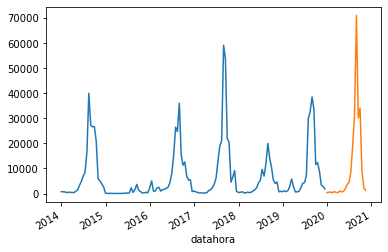

In [31]:
y_train.riscofogo.plot()
y_test.riscofogo.plot()

<AxesSubplot:xlabel='datahora'>

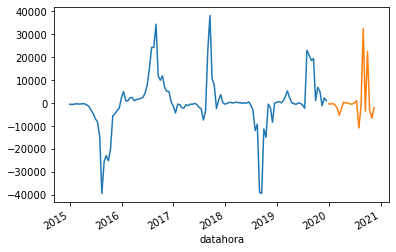

In [32]:
y_train.seasonal_diff.plot()
y_test.seasonal_diff.plot()

## Understanding the ACF and the PACF

From the ACF and PACF plots we observe that the functions are correlated
with the 3-4 data previously to that. And we also observer regular peaks 
each 24 data (as expected), these are related to the seasonality of our data.

Let's now create th possible values for our model.

In [6]:
p = range(0,3)
d = range(0,1)
q = range(0,4)

pdq = list(itertools.product(p, d, q))                                 ## pdq values
pdqs = [(p, d, q, 24) for p, d, q in itertools.product(p, d, q)]       ## pdq values for the seasonal part

pdqs

[(0, 0, 0, 24),
 (0, 0, 1, 24),
 (0, 0, 2, 24),
 (0, 0, 3, 24),
 (1, 0, 0, 24),
 (1, 0, 1, 24),
 (1, 0, 2, 24),
 (1, 0, 3, 24),
 (2, 0, 0, 24),
 (2, 0, 1, 24),
 (2, 0, 2, 24),
 (2, 0, 3, 24)]

Now lets start the investigation itself of the parameters by analyzing the
[AIC value](https://en.wikipedia.org/wiki/Akaike_information_criterion) for each model.
We are going to create a dicitionary containing the model parametes and the corresponding
AIC value of it. Afterwards we can choose the best model.

We start by analyzing the model for *riscofogo* column (since we are going to implement
SARIMA instead of ARIMA and afterwards we are going to implement it for the *seasonal_diff*
column.

In [29]:
aic_model_dict = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(y_train.riscofogo, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_aic = sarimax.fit()
            
        print ('Model : {} x {}; AIC : {}'.format(param, seasonal_param, model_aic.aic))
        aic_model_dict[(param, seasonal_param)] = model_aic.aic

Model : (0, 0, 0) x (0, 0, 0, 24); AIC : 3730.798165778464
Model : (0, 0, 0) x (0, 0, 1, 24); AIC : 3102.5119314337217


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (0, 0, 0) x (0, 0, 2, 24); AIC : 2421.3395948324114
Model : (0, 0, 0) x (0, 0, 3, 24); AIC : 1820.2208882600673
Model : (0, 0, 0) x (1, 0, 0, 24); AIC : 3062.6436776317832
Model : (0, 0, 0) x (1, 0, 1, 24); AIC : 2992.7452247532233
Model : (0, 0, 0) x (1, 0, 2, 24); AIC : 2391.390503239143
Model : (0, 0, 0) x (1, 0, 3, 24); AIC : 1787.046432833234
Model : (0, 0, 0) x (2, 0, 0, 24); AIC : 2394.8573241156423
Model : (0, 0, 0) x (2, 0, 1, 24); AIC : 2381.5923422238293
Model : (0, 0, 0) x (2, 0, 2, 24); AIC : 2387.8774410623637
Model : (0, 0, 0) x (2, 0, 3, 24); AIC : 1789.0328733819888
Model : (0, 0, 1) x (0, 0, 0, 24); AIC : 3604.5553785722313
Model : (0, 0, 1) x (0, 0, 1, 24); AIC : 2993.072042218579
Model : (0, 0, 1) x (0, 0, 2, 24); AIC : 2377.1085003080952
Model : (0, 0, 1) x (0, 0, 3, 24); AIC : 1775.0430470711544
Model : (0, 0, 1) x (1, 0, 0, 24); AIC : 3031.7190099743802
Model : (0, 0, 1) x (1, 0, 1, 24); AIC : 2966.253269732816
Model : (0, 0, 1) x (1, 0, 2, 24); AIC : 236

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (1, 0, 3, 24); AIC : 1717.872734722708
Model : (0, 0, 3) x (2, 0, 0, 24); AIC : 2420.4327224792096
Model : (0, 0, 3) x (2, 0, 1, 24); AIC : 2420.9580047312716
Model : (0, 0, 3) x (2, 0, 2, 24); AIC : 2321.3238119129


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (2, 0, 3, 24); AIC : 1719.3579854402903
Model : (1, 0, 0) x (0, 0, 0, 24); AIC : 3529.484176746413
Model : (1, 0, 0) x (0, 0, 1, 24); AIC : 2942.8579302097824
Model : (1, 0, 0) x (0, 0, 2, 24); AIC : 2345.3640902597044
Model : (1, 0, 0) x (0, 0, 3, 24); AIC : 1766.5036934667987
Model : (1, 0, 0) x (1, 0, 0, 24); AIC : 2934.5434034874784
Model : (1, 0, 0) x (1, 0, 1, 24); AIC : 2910.146272718424
Model : (1, 0, 0) x (1, 0, 2, 24); AIC : 2336.0841557297613
Model : (1, 0, 0) x (1, 0, 3, 24); AIC : 1754.315934371849
Model : (1, 0, 0) x (2, 0, 0, 24); AIC : 2337.700972000446
Model : (1, 0, 0) x (2, 0, 1, 24); AIC : 2334.7309614425444
Model : (1, 0, 0) x (2, 0, 2, 24); AIC : 2336.7266669436713
Model : (1, 0, 0) x (2, 0, 3, 24); AIC : 1756.3107478967895
Model : (1, 0, 1) x (0, 0, 0, 24); AIC : 3502.809005811997
Model : (1, 0, 1) x (0, 0, 1, 24); AIC : 2917.9553785925386
Model : (1, 0, 1) x (0, 0, 2, 24); AIC : 2322.39211224707
Model : (1, 0, 1) x (0, 0, 3, 24); AIC : 1741.4

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 0, 3, 24); AIC : 1682.799663467757
Model : (2, 0, 0) x (0, 0, 0, 24); AIC : 3502.1602636356056
Model : (2, 0, 0) x (0, 0, 1, 24); AIC : 2941.155701310634
Model : (2, 0, 0) x (0, 0, 2, 24); AIC : 2346.0281798952124
Model : (2, 0, 0) x (0, 0, 3, 24); AIC : 1765.8921735198116
Model : (2, 0, 0) x (1, 0, 0, 24); AIC : 2910.738169230059
Model : (2, 0, 0) x (1, 0, 1, 24); AIC : 2887.344433356846
Model : (2, 0, 0) x (1, 0, 2, 24); AIC : 2337.197151346016
Model : (2, 0, 0) x (1, 0, 3, 24); AIC : 1751.3367190245435
Model : (2, 0, 0) x (2, 0, 0, 24); AIC : 2314.4884228799624
Model : (2, 0, 0) x (2, 0, 1, 24); AIC : 2311.788179524897
Model : (2, 0, 0) x (2, 0, 2, 24); AIC : 2313.7793454597695
Model : (2, 0, 0) x (2, 0, 3, 24); AIC : 1753.2884696224385
Model : (2, 0, 1) x (0, 0, 0, 24); AIC : 3502.843172782954
Model : (2, 0, 1) x (0, 0, 1, 24); AIC : 2918.47675139636
Model : (2, 0, 1) x (0, 0, 2, 24); AIC : 2324.297998244868
Model : (2, 0, 1) x (0, 0, 3, 24); AIC : 1739.9178

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (1, 0, 3, 24); AIC : 1704.9504687083008
Model : (2, 0, 2) x (2, 0, 0, 24); AIC : 2317.9266225356864
Model : (2, 0, 2) x (2, 0, 1, 24); AIC : 2313.469810253654
Model : (2, 0, 2) x (2, 0, 2, 24); AIC : 2291.4380122693137


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 3, 24); AIC : 1706.892569510835
Model : (2, 0, 3) x (0, 0, 0, 24); AIC : 3452.2571203406123
Model : (2, 0, 3) x (0, 0, 1, 24); AIC : 2866.2714388278464
Model : (2, 0, 3) x (0, 0, 2, 24); AIC : 2279.4641618660658
Model : (2, 0, 3) x (0, 0, 3, 24); AIC : 1695.562426476028
Model : (2, 0, 3) x (1, 0, 0, 24); AIC : 2908.851659382344
Model : (2, 0, 3) x (1, 0, 1, 24); AIC : 2843.4553964476468
Model : (2, 0, 3) x (1, 0, 2, 24); AIC : 2268.276745517251


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (1, 0, 3, 24); AIC : 1681.0774380282862
Model : (2, 0, 3) x (2, 0, 0, 24); AIC : 2319.401441319999
Model : (2, 0, 3) x (2, 0, 1, 24); AIC : 2314.764659768476
Model : (2, 0, 3) x (2, 0, 2, 24); AIC : 2269.1055699379253


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 0, 3, 24); AIC : 1682.2369545440504


In [36]:
for key in aic_model_dict:
    if aic_model_dict[key] < 1690:
        print (key, aic_model_dict[key])

((1, 0, 3), (1, 0, 3, 24)) 1680.8845180263957
((1, 0, 3), (2, 0, 3, 24)) 1682.799663467757
((2, 0, 3), (1, 0, 3, 24)) 1681.0774380282862
((2, 0, 3), (2, 0, 3, 24)) 1682.2369545440504


## Convergence issues for the best models using the riscofogo model

the best models using riscofogo were having some issues regarding
the convergence of the likelihood optimization. Let's try to increase
order of $p$ and $q$ in one unity.

In [41]:
aic_model_dict_diff = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax_diff = sm.tsa.statespace.SARIMAX(y_train.seasonal_diff, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_aic_diff = sarimax_diff.fit()
            
        print ('Model : {} x {}; AIC : {}'.format(param, seasonal_param, model_aic_diff.aic))
        aic_model_dict_diff[(param, seasonal_param)] = model_aic_diff.aic

Model : (0, 0, 0) x (0, 0, 0, 24); AIC : 3066.849641911106
Model : (0, 0, 0) x (0, 0, 1, 24); AIC : 3033.156592877414


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (0, 0, 0) x (0, 0, 2, 24); AIC : 2386.4748978337448
Model : (0, 0, 0) x (0, 0, 3, 24); AIC : 1789.12789478757
Model : (0, 0, 0) x (1, 0, 0, 24); AIC : 2985.7642891594433
Model : (0, 0, 0) x (1, 0, 1, 24); AIC : 2957.0502699292256
Model : (0, 0, 0) x (1, 0, 2, 24); AIC : 2382.96857094863
Model : (0, 0, 0) x (1, 0, 3, 24); AIC : 1790.2793408700336
Model : (0, 0, 0) x (2, 0, 0, 24); AIC : 2386.7994563084812
Model : (0, 0, 0) x (2, 0, 1, 24); AIC : 2376.6474289805346
Model : (0, 0, 0) x (2, 0, 2, 24); AIC : 2379.5013941205552
Model : (0, 0, 0) x (2, 0, 3, 24); AIC : 1787.3891369131766
Model : (0, 0, 1) x (0, 0, 0, 24); AIC : 3006.6516530722265
Model : (0, 0, 1) x (0, 0, 1, 24); AIC : 2932.370644171816
Model : (0, 0, 1) x (0, 0, 2, 24); AIC : 2334.311510200743
Model : (0, 0, 1) x (0, 0, 3, 24); AIC : 1739.8229224366303
Model : (0, 0, 1) x (1, 0, 0, 24); AIC : 2974.454516175067
Model : (0, 0, 1) x (1, 0, 1, 24); AIC : 2927.0895059411164
Model : (0, 0, 1) x (1, 0, 2, 24); AIC : 2333.5

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 0, 3, 24); AIC : 1689.2731702935405
Model : (2, 0, 0) x (0, 0, 0, 24); AIC : 2983.759035515285
Model : (2, 0, 0) x (0, 0, 1, 24); AIC : 2931.04080960555
Model : (2, 0, 0) x (0, 0, 2, 24); AIC : 2343.545012334934
Model : (2, 0, 0) x (0, 0, 3, 24); AIC : 1758.8906040881657
Model : (2, 0, 0) x (1, 0, 0, 24); AIC : 2901.806585565672
Model : (2, 0, 0) x (1, 0, 1, 24); AIC : 2903.612153107743
Model : (2, 0, 0) x (1, 0, 2, 24); AIC : 2342.8089916820395
Model : (2, 0, 0) x (1, 0, 3, 24); AIC : 1759.1141505636588
Model : (2, 0, 0) x (2, 0, 0, 24); AIC : 2317.499249749355
Model : (2, 0, 0) x (2, 0, 1, 24); AIC : 2318.0406080180937
Model : (2, 0, 0) x (2, 0, 2, 24); AIC : 2320.7470557609668
Model : (2, 0, 0) x (2, 0, 3, 24); AIC : 1760.5179292988719
Model : (2, 0, 1) x (0, 0, 0, 24); AIC : 2985.44464262681
Model : (2, 0, 1) x (0, 0, 1, 24); AIC : 2908.1290130284715
Model : (2, 0, 1) x (0, 0, 2, 24); AIC : 2320.4273289208254
Model : (2, 0, 1) x (0, 0, 3, 24); AIC : 1731.442

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 0, 2, 24); AIC : 16.0


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 0, 3, 24); AIC : 589.2609600656344
Model : (2, 0, 2) x (0, 0, 0, 24); AIC : 2985.9457495536617
Model : (2, 0, 2) x (0, 0, 1, 24); AIC : 2886.9860734805993
Model : (2, 0, 2) x (0, 0, 2, 24); AIC : 2298.970117643165


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (0, 0, 3, 24); AIC : 16.0
Model : (2, 0, 2) x (1, 0, 0, 24); AIC : 2906.517302679153
Model : (2, 0, 2) x (1, 0, 1, 24); AIC : 2883.853791283623
Model : (2, 0, 2) x (1, 0, 2, 24); AIC : 2299.0826241379414
Model : (2, 0, 2) x (1, 0, 3, 24); AIC : 18.0
Model : (2, 0, 2) x (2, 0, 0, 24); AIC : 2321.130834092402
Model : (2, 0, 2) x (2, 0, 1, 24); AIC : 2321.382880919083
Model : (2, 0, 2) x (2, 0, 2, 24); AIC : 2301.0488014707776


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 3, 24); AIC : 1713.2956600577256
Model : (2, 0, 3) x (0, 0, 0, 24); AIC : 2985.0366900606386
Model : (2, 0, 3) x (0, 0, 1, 24); AIC : 2864.19455825353
Model : (2, 0, 3) x (0, 0, 2, 24); AIC : 2277.00615385969
Model : (2, 0, 3) x (0, 0, 3, 24); AIC : 1687.4843382841327
Model : (2, 0, 3) x (1, 0, 0, 24); AIC : 2908.531373986933
Model : (2, 0, 3) x (1, 0, 1, 24); AIC : 2861.60600699981
Model : (2, 0, 3) x (1, 0, 2, 24); AIC : 2277.226654853673


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (1, 0, 3, 24); AIC : 1688.2350998710788
Model : (2, 0, 3) x (2, 0, 0, 24); AIC : 2323.2085370374166
Model : (2, 0, 3) x (2, 0, 1, 24); AIC : 2323.3920787858524
Model : (2, 0, 3) x (2, 0, 2, 24); AIC : 2279.1941967459206


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 0, 3, 24); AIC : 1688.225702459406


In [42]:
for key in aic_model_dict_diff:
    if aic_model_dict_diff[key] < 1000:
        print (key, aic_model_dict_diff[key])

((2, 0, 1), (1, 0, 1, 24)) 12.0
((2, 0, 1), (2, 0, 0, 24)) 12.0
((2, 0, 1), (2, 0, 1, 24)) 14.0
((2, 0, 1), (2, 0, 2, 24)) 16.0
((2, 0, 1), (2, 0, 3, 24)) 589.2609600656344
((2, 0, 2), (0, 0, 3, 24)) 16.0
((2, 0, 2), (1, 0, 3, 24)) 18.0


In [9]:
### MODELS ACQUIRED BY TESTING THE AIC

#((1, 0, 3), (1, 0, 3, 24)) 1680.8845180263957
#((1, 0, 3), (2, 0, 3, 24)) 1682.799663467757
#((2, 0, 3), (1, 0, 3, 24)) 1681.0774380282862
#((2, 0, 3), (2, 0, 3, 24)) 1682.2369545440504


### MODEL ACQUIRED ANALYZING ACF AND PACF
# (3, 0, 3), (2, 0, 1, 24) ## seasonal p = 2 or 3


my_order = (2, 0, 3)
my_sorder = (2, 0, 1, 24) 

model_riscofogo = sm.tsa.statespace.SARIMAX(y_train.riscofogo,
                                            order = my_order,
                                            seasonal_order = my_sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

model_riscofogo_fit = model_riscofogo.fit()

In [127]:
print(model_riscofogo_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            riscofogo   No. Observations:                  144
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 24)   Log Likelihood               -1148.382
Date:                              Tue, 08 Dec 2020   AIC                           2314.765
Time:                                      14:56:03   BIC                           2337.654
Sample:                                  12-31-2013   HQIC                          2324.010
                                       - 12-15-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3516      1.932      0.182      0.856      -3.434       4.137
ar.L2          0.07

In [10]:
predictions = model_riscofogo_fit.forecast(len(y_test))

residuals = y_test.riscofogo - predictions

residuals.tail(10)

datahora
2020-06-30    -10881.846892
2020-07-15    -14656.576362
2020-07-31     87426.816882
2020-08-15    199103.328942
2020-08-31    479749.336778
2020-09-15     69468.499042
2020-09-30    250914.862519
2020-10-15    -15350.084379
2020-10-31    -23692.407883
2020-11-15    -32438.068363
Freq: SM-15, dtype: float64

In [129]:
MAE = np.mean(abs(residuals/y_test.riscofogo))

print ('Mean absolute error in percentage : {}'.format(round(100*MAE, 2)))

Mean absolute error in percentage : 62.43


 we see that the error is quite high, let's analyze it graphically to help us
understand why the model is doing so

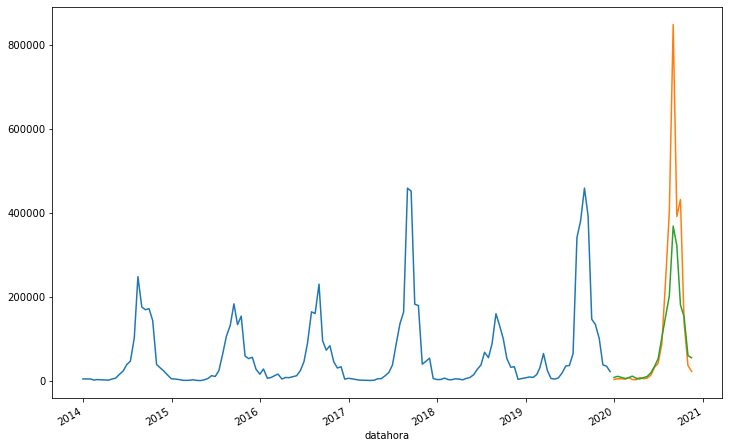

In [130]:
fig, ax = plt.subplots(figsize = (12, 8))

y_train.riscofogo.plot()
y_test.riscofogo.plot()
predictions.plot()

plt.show()

Okay, so it is easy to understand why: the years 2014, 2015, 2016
have roughly the same amplitudes. In 2017 there is this bigger peak
(compared to previous years), than one has a  small peak in 2018 
and a bigger one in 2019 (comparable to the 2017 one). The model
predicted that compared to the previous ones this year we were
going to have a slightly smaller peak compared to 2019. But this was
not the cause though. We had a huge increament. There is the chance
of the satellite data have being acquired more frequently and therefore
(by the analysis that we have performed) it led us to obtain a bigger
number of burning events. To investigate this we would need to count
the frequency of data registration along the years and normalize it
(perhaps do a daily normnalization on the data, that would fix that
in the sense of: we have much more data due tho the fact that it was
acquired much more frequently, but we are also dividing by this big number).

However, there is a different approach that we can make before doing
this, which would allow us to refine our model (which might also be helpful
within the near future). We can make use of a technique called *Rolling Forecast Origin* (RFO).
The RFO technique consists in instead of predicting what is going to happen
in the entire year, one makes a prediction for the next few months based
on what we know until now, then for the sequent month we update the model
and and carry on this analysis. It is a kind of a self correction for
for long time period models. The main issue here is related to the
order of our moving average model (consequently, the order of the
correlation function). Since our model is of order three, we can only
confidently predict one to one month and half in advance. Afterwards
the model stabilizes at its mean value (please note the value of the highest peak)
of our prediction). The next section is devoted to implementing it.

In [12]:
# monthly prediction

rfo_predictions = pd.Series()


for data_end in y_test.index:
    y_data_for = df_all[: data_end - relativedelta(months = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.fit()
    pred = model_fit.predict(data_end)
    rfo_predictions.loc[data_end] = pred.loc[data_end]

<ipython-input-12-ab17981405cd>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rfo_predictions = pd.Series()


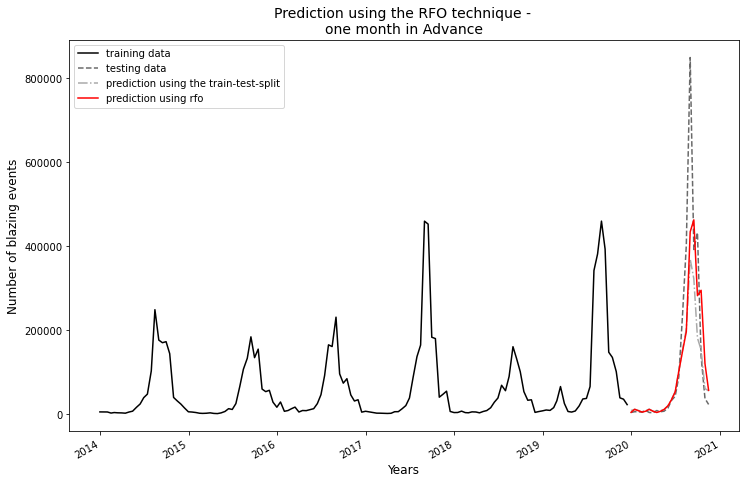

In [89]:
fig, ax = plt.subplots(figsize = (12, 8))



ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions, label = 'prediction using rfo', color = 'red')

ax.set_ylabel('Number of fire events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 14)

plt.legend()

plt.show()



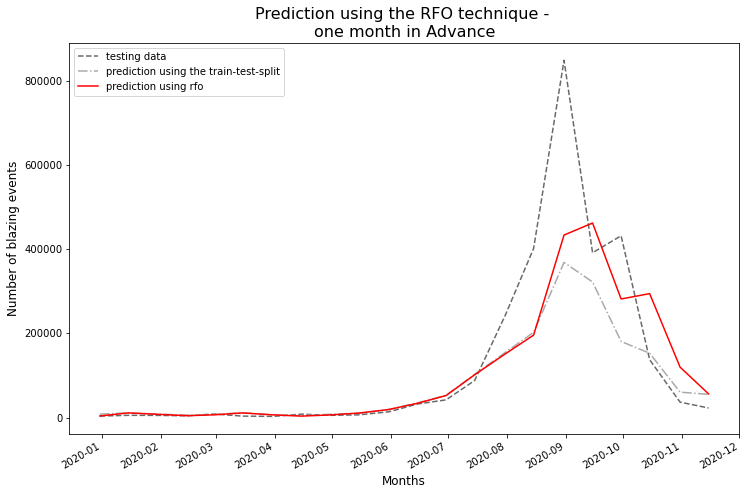

In [90]:
fig, ax = plt.subplots(figsize = (12, 8))


ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions, label = 'prediction using rfo', color = 'red')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of fire events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 16)

plt.legend()

plt.show()

In [13]:
# biweekly prediction

rfo_predictions_bw = pd.Series()


for data_end in y_test.index:
    y_data_for = df_all[: data_end - timedelta(days = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.fit()
    pred = model_fit.predict(data_end)
    rfo_predictions_bw.loc[data_end] = pred.loc[data_end]

<ipython-input-13-6e5fe23a9abb>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rfo_predictions_bw = pd.Series()


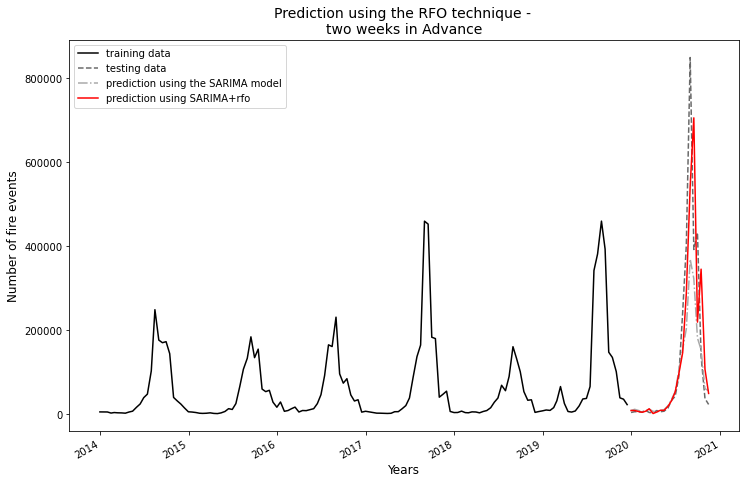

In [66]:
fig, ax = plt.subplots(figsize = (12, 8))



ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the SARIMA model', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions_bw, label = 'prediction using SARIMA+rfo', color = 'red')

ax.set_ylabel('Number of fire events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \ntwo weeks in Advance', fontsize = 14)

plt.legend()

plt.show()

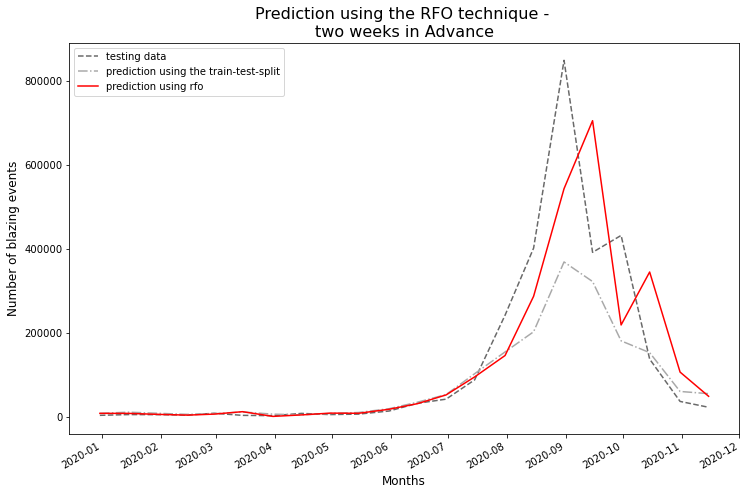

In [92]:
fig, ax = plt.subplots(figsize = (12, 8))


ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions_bw, label = 'prediction using rfo', color = 'red')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of fire events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \ntwo weeks in Advance', fontsize = 16)

plt.legend()

plt.show()

## Residuals analysis

This time we are going to analyse the residuals of each model, *i.e.,* SARIMA,
SARIMA+rfo for one month and SARIMA +rfo for two weeks. We observe by [this plot](#plot-rfo)
that we apparently we got a better result in fiting the curve. However, we observe a shift
in between them, consequently it is worth to investigate how much it is indeed better then
the simple SARIMA model.

At first, let's start analyzing the residual for both situations

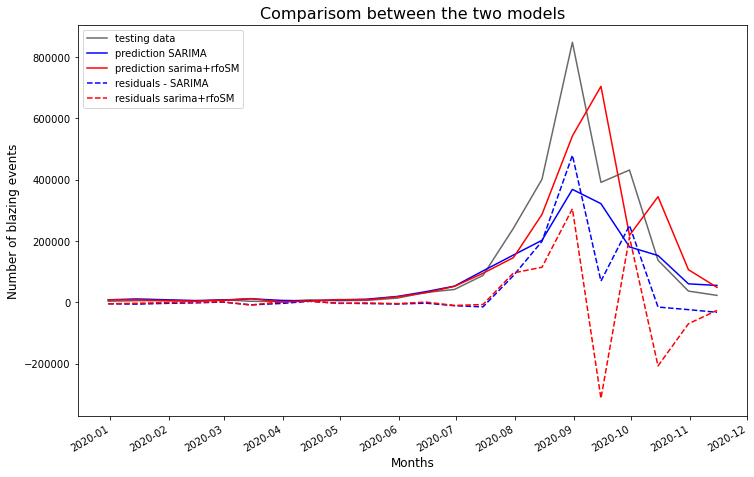

In [15]:
fig, ax = plt.subplots(figsize = (12, 8))


residuals_rfo_bw = y_test.riscofogo - rfo_predictions_bw# residuals for rfo ands biweekly data

ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey')
ax.plot(predictions, label = 'prediction SARIMA ', color = 'blue')
ax.plot(rfo_predictions_bw, label = 'prediction sarima+rfoSM', color = 'red')
ax.plot(residuals, label = 'residuals - SARIMA', color = 'blue', linestyle = '--')
ax.plot(residuals_rfo_bw, label = 'residuals sarima+rfoSM', color = 'red', linestyle = '--')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of fire events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Comparisom between the two models', fontsize = 16)

plt.legend()

plt.show()

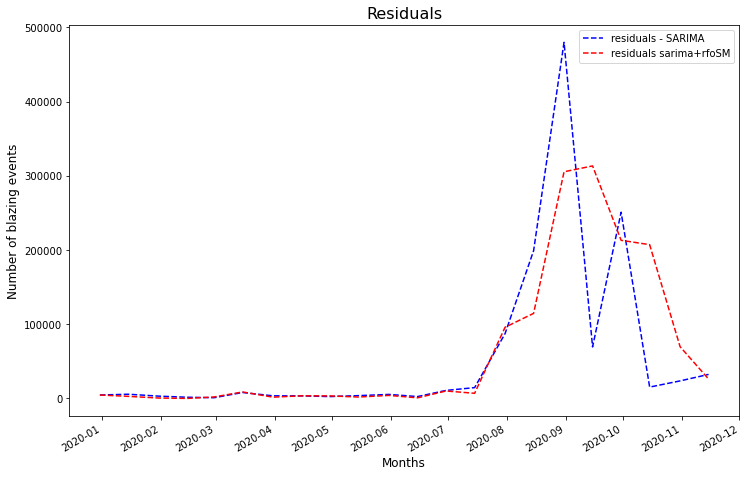

In [16]:
## As we obseve the residuals in the prediction that was apparently good, is not as good as expected.
## To have a better idea lets compare the residuals themselves


fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(abs(residuals), label = 'residuals - SARIMA', color = 'blue', linestyle = '--')
ax.plot(abs(residuals_rfo_bw), label = 'residuals sarima+rfoSM', color = 'red', linestyle = '--')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of fire events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Residuals', fontsize = 16)

plt.legend()

plt.show()

In [17]:
MAE_bw = np.mean(abs(residuals_rfo_bw/y_test.riscofogo))

print ('Mean absolute error in percentage for SARIMA+biweekly rfo : {}'.format(round(100*MAE_bw, 2)))

MAE = np.mean(abs(residuals/y_test.riscofogo))

print ('Mean absolute error in percentage for SARIMA : {}'.format(round(100*MAE, 2)))

Mean absolute error in percentage for SARIMA+biweekly rfo : 64.54
Mean absolute error in percentage for SARIMA : 62.43


## conclusion about the error analysis

So, analyzing the plots above we observe that: despite of better capturing
the peak size, in an attempt to capture it, the rfo technique shifts it to the left,
leading to a mismatch between the real data and the prediction. The latter is so relevant
that the mean absolute error is essentially the same.

## Possibilities to be tested

Okay, so what we can do now: there is this issue about counting the number of data acquisition
to check whether there is or not data being acquired more frequently. But another interesting
feature that we can observe in the [data](#total-series) is that: from 2014 to 2016 there were
the peaks with regular height (group $I$). Then in 2017 the peak was much more pronounced (group $II$).
In 2018 there was a smaller peak, comparable to those in group $I$. In 2019 the peak
increased again comparable to the group $II$ on and in 2020 the peak was much higher than those
seen before, belonging to a "new category", group $III$.

By what we can see, group $III$ is for sure an anomaly event. But what about these two other events
belonging to group $II$, are they also anomalies? To understand that we need to gather more data
from the [INPE dataset](http://queimadas.dgi.inpe.br/queimadas/bdqueimadas) and check what has happened
in previous years. For doing so, we might not be able to make a good prediction for the year of 2020
right away, but we will be able to analyse better the possible anomaly events in group (II), handle them,
and make a more robust model. So, without further ado, let's get it started:


## Loading more data for anomalies handling

In [21]:
# creating the simplified datasets

names = ['data2010', 'data2011', 'data2012', 'data2013']

for name in names:
    df = pd.read_csv('../../dataset/{}.csv'.format(name), index_col = 'datahora', parse_dates = True)
    df = df[df.riscofogo == 1]
    df_biweekly = df.resample('SM')['riscofogo'].sum().sort_index()
    df_biweekly.to_csv('../../sm-dataset/{}_biweekly.csv'.format(name))

In [2]:
df2010 = pd.read_csv('../../sm-dataset/data2010_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2011 = pd.read_csv('../../sm-dataset/data2011_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2012 = pd.read_csv('../../sm-dataset/data2012_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2013 = pd.read_csv('../../sm-dataset/data2013_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2014 = pd.read_csv('../../sm-dataset/data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../sm-dataset/data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../sm-dataset/data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../sm-dataset/data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../sm-dataset/data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2019 = pd.read_csv('../../sm-dataset/data2019_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2020 = pd.read_csv('../../sm-dataset/data2020_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018, df2019, df2020]
                  ).sort_index()

## Since there are duplicated indexes we need to sum them up

df_all = df_all.groupby(df_all.index).sum()

## Handling future *frequency warnings*

df_all = df_all.asfreq('SM')

df_all.index

DatetimeIndex(['2013-12-31', '2014-01-15', '2014-01-31', '2014-02-15',
               '2014-02-28', '2014-03-15', '2014-03-31', '2014-04-15',
               '2014-04-30', '2014-05-15',
               ...
               '2020-06-30', '2020-07-15', '2020-07-31', '2020-08-15',
               '2020-08-31', '2020-09-15', '2020-09-30', '2020-10-15',
               '2020-10-31', '2020-11-15'],
              dtype='datetime64[ns]', name='datahora', length=166, freq='SM-15')

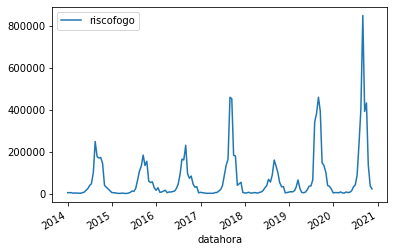

In [57]:
df_all.plot()
plt.show()

In [62]:
# There is something weird with the dataframe, let's take a closer look


df2010 = pd.read_csv('../../dataset/data2010.csv',
                     index_col = 'datahora', usecols = ['riscofogo', 'datahora'],
                     parse_dates = True)
df2011 = pd.read_csv('../../dataset/data2011.csv',
                     index_col = 'datahora', usecols = ['riscofogo', 'datahora'],
                     parse_dates = True)
df2012 = pd.read_csv('../../dataset/data2012.csv',
                     index_col = 'datahora', usecols = ['riscofogo', 'datahora'],
                     parse_dates = True)
df2013 = pd.read_csv('../../dataset/data2013.csv',
                     index_col = 'datahora', usecols = ['riscofogo', 'datahora'],
                     parse_dates = True)

In [63]:
print(df2010.riscofogo.notna().sum())
print(df2011.riscofogo.notna().sum())
print(df2012.riscofogo.notna().sum())
print(df2013.riscofogo.notna().sum())

0
0
0
0


Okay, so apparently there is no data avaiable  for riscofogo for these previous years

In [64]:
df2010 = pd.read_csv('../../dataset/data2010.csv',
                     index_col = 'datahora',
                     parse_dates = True)

In [71]:
df2010.head(20)

,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
datahora,,,,,,,,,,,
2010-01-01 01:21:19,NOAA-17,Brasil,RORAIMA,PACARAIMA,Amazonia,NaN,NaN,NaN,4.5133,-60.8516,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazonia,NaN,NaN,NaN,4.5360,-60.8710,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazonia,NaN,NaN,NaN,4.5280,-60.8670,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,AMAJARI,Amazonia,NaN,NaN,NaN,3.8450,-61.1000,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazonia,NaN,NaN,NaN,4.5390,-60.8510,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,AMAJARI,Amazonia,NaN,NaN,NaN,3.8360,-61.1180,NaN
2010-01-01 02:03:00,TERRA_M-M,Brasil,RORAIMA,AMAJARI,Amazonia,NaN,NaN,NaN,3.8390,-61.0940,NaN
2010-01-01 02:06:49,ATSR,Brasil,RORAIMA,CARACARAI,Amazonia,NaN,NaN,NaN,1.2150,-60.4540,NaN
2010-01-01 02:07:44,ATSR,Brasil,RORAIMA,PACARAIMA,Amazonia,NaN,NaN,NaN,4.5400,-60.8590,NaN


# Following steps


So, let's make the prediction for the year o 2018 (based on previous years).
After building the model, we will try to handle the anomaly which happened in 2017
and see how it improves the model accuracy. This kind of technique might be quite
handy after getting more data, since we will be able to know whether the peaks in 2017
and 2019 are anomalies or not (for making a more robust model and check what was supposed
to be the number of fire events this year).

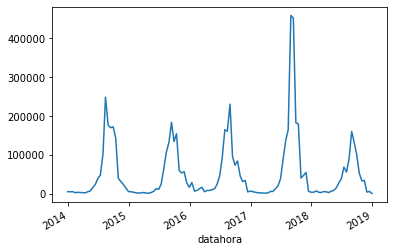

In [2]:
df2014 = pd.read_csv('../../sm-dataset/data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../sm-dataset/data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../sm-dataset/data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../sm-dataset/data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../sm-dataset/data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2014, df2015, df2016, df2017, df2018]).sort_index()

df_all = df_all.groupby(df_all.index).sum()

df_all = df_all.asfreq('SM')

df_all.riscofogo.plot()

plt.show()

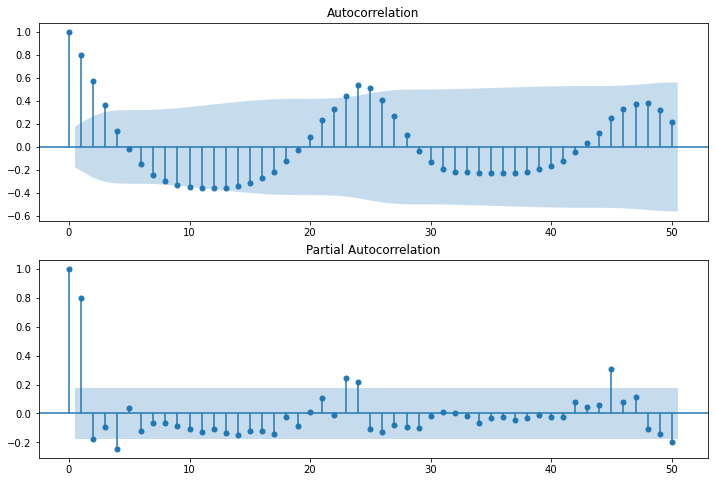

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=50,ax=ax1)
plot_pacf(df_all.dropna(),lags=50,ax=ax2)

#fig.suptitle('seasonal difference data', fontsize=16)
plt.show()

(4, 0, 3)
(3, 0, 1)

## Getting the SARIMA model parameters

By analyzing ACF we get q = 3 and Q = 1-3

By analyzing PACF we get p = 4 and P = 1-2

In [4]:
y_train = df_all[:len(df_all) - 24]
y_test = df_all[len(df_all) - 24:]

In [5]:
y_train.tail()

,riscofogo
datahora,
2017-10-31,39992.0
2017-11-15,46848.0
2017-11-30,54362.0
2017-12-15,6047.0
2017-12-31,3406.0


In [6]:
y_test.head()

,riscofogo
datahora,
2018-01-15,3579.0
2018-01-31,6809.0
2018-02-15,3327.0
2018-02-28,2851.0
2018-03-15,5062.0


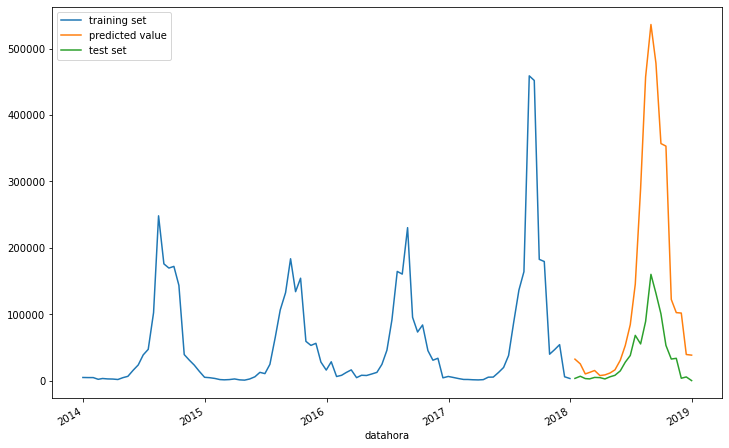

In [7]:
my_order = (1, 0, 3)
my_sorder = (2, 0, 1, 24) 

model = sm.tsa.statespace.SARIMAX(y_train.riscofogo,
                                  order = my_order,
                                  seasonal_order = my_sorder,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_fit = model.fit()

predictions = model_fit.forecast(len(y_test))


plt.figure(figsize = (12,8))
y_train.riscofogo.plot(label = 'training set')
predictions.plot(label = 'predicted value')
y_test.riscofogo.plot(label = 'test set')

plt.legend()
plt.show()

## Handling the anomaly in 2017 for a better prediction

### A more qualitative approach

There are several ways of taking into consideration that there is an anomaly
event within the data set. One of them is to analyse the standard deviation
for a given semimonth (in this case) and analyze how it changes across years.

We might expect a pretty high value for the standard deviation within the fire period
due to the anomaly, due to its lot of variability for different years within this period.

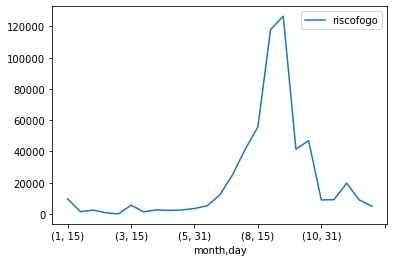

In [8]:
semimonth_deviation = df_all.groupby([df_all.index.month, df_all.index.day]).std(ddof = 0)
semimonth_deviation.index = semimonth_deviation.index.rename(names = ['month', 'day'])

semimonth_deviation.plot()
plt.show()

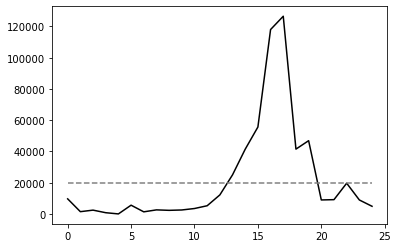

In [9]:
## Let's set a threshold for this anomaly events

threshold = 20000*np.ones(len(semimonth_deviation))

fig, ax = plt.subplots()

ax.plot(np.array(semimonth_deviation), color = 'k')
ax.plot(threshold, linestyle = '--', c = 'grey')
plt.show()

In [10]:
## Identifying the anomaly period

anomaly_region = semimonth_deviation[semimonth_deviation > 20000].copy().dropna()
anomaly_region

riscofogo
month day               
7     15    25013.565627
      31    41424.733660
8     15    55615.093338
      31   118016.817848
9     15   126522.940504
      30    41472.064060
10    15    46876.899307

## A more quantitative approach

In [11]:
## seasonal trend decomposition 

stl = STL(df_all, period = 24) ## Since we have semimonth data
decomposition = stl.fit()

In [12]:
seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

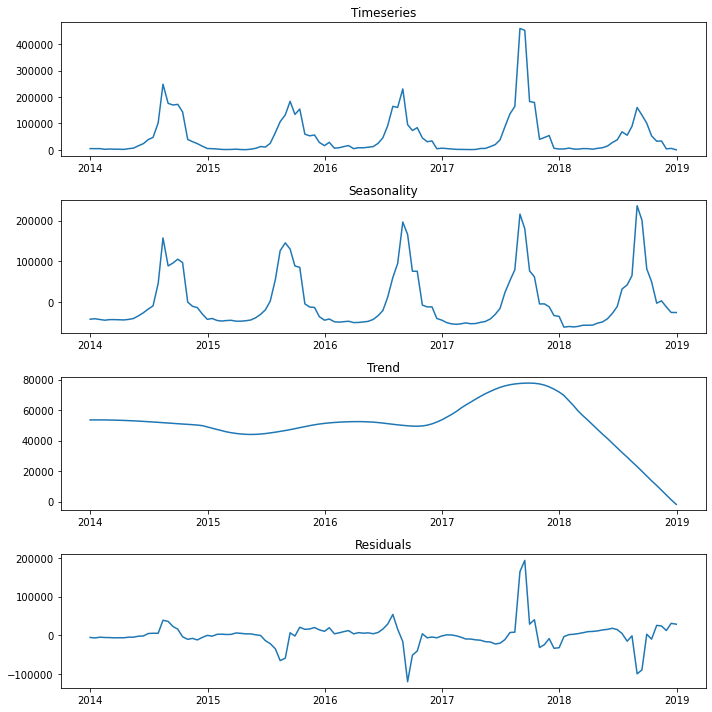

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all)
ax1.set_title('Timeseries')
ax2.plot(seasonal)
ax2.set_title('Seasonality')
ax3.plot(trend)
ax3.set_title('Trend')
ax4.plot(residuals)
ax4.set_title('Residuals')


plt.tight_layout()
plt.show()

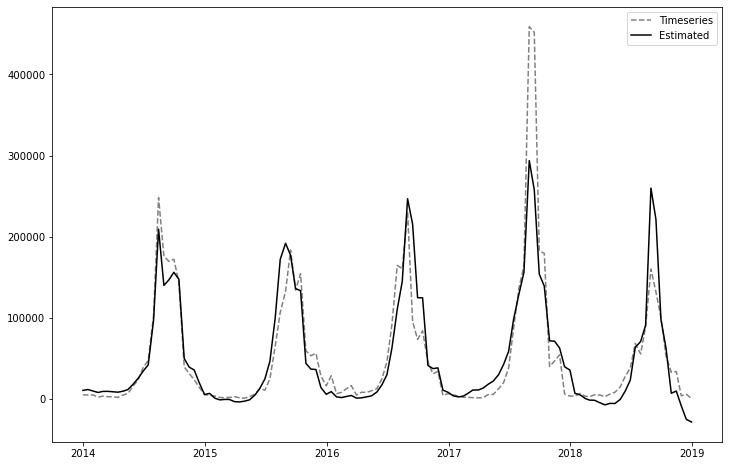

In [14]:
## Getting the difference due to the residuals

plt.figure(figsize = (12,8))
plt.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
plt.plot(seasonal+trend, label = "Estimated", c = 'k')
plt.legend()
plt.show()

## Brief discussion about the above result

By the result above, we observe that the difference between the estimated curve and
the real timeseries is entirely due to the residuals. What is left for us is to decide
whether these residuals are anomalies or not. For example, for sure in 2017 there is an
anomaly event, as discussed previously. Now what we want is to analyze other mismatches,
for example, like the one in 2014. *Is that an anomaly as well?* To  do so, we need to quantify
it better. Let's then analyze the residuals in greater detail

In [15]:
residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Getting the lower and upper values of it

lower = residuals_mean - 3*residuals_std
upper = residuals_mean + 3*residuals_std

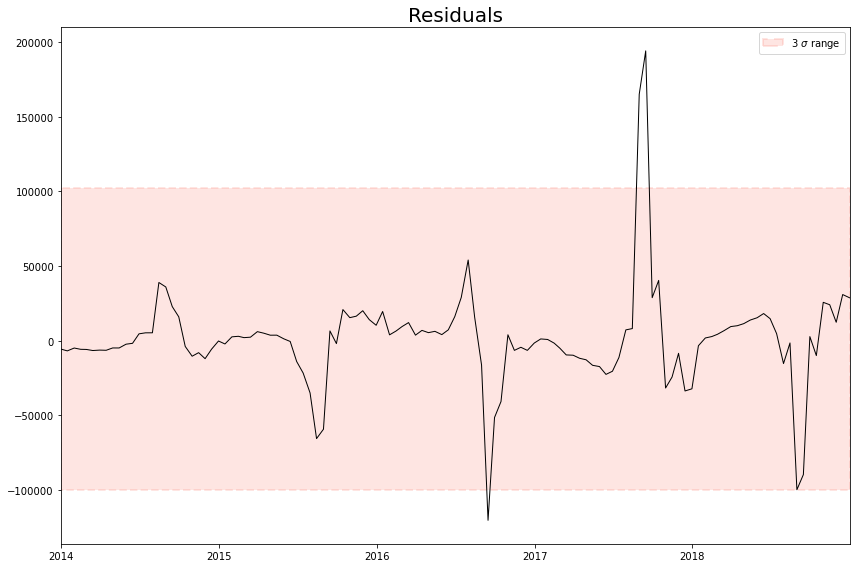

In [16]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(residuals, color = 'k', linewidth = 1)

ax.fill_between([df_all.index[0], df_all.index[-1]], lower, upper,
                label = '3 $\sigma$ range',
                color = 'salmon', alpha = 0.2,
                linestyle = '--', linewidth = 2)

ax.set_xlim(df_all.index[0], df_all.index[-1])

ax.set_title('Residuals', fontsize = 20)

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
## And we observe that accordingly, we have two points almost a third one
## which can be considered  as anomalies. Lets show them on the original plot

anomaly_dates = df_all[(residuals > upper) | (residuals < lower)]

anomaly_dates

## Ah okay, the point in 2018 is not an anomaly per se, but within the peak of 2017
## there are two points (end Augst and beginning of September)

,riscofogo
datahora,
2016-09-15,95478.0
2017-08-31,458846.0
2017-09-15,451911.0


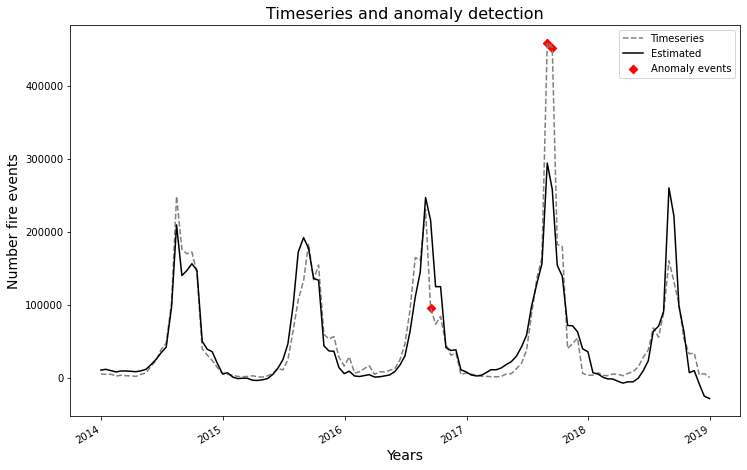

In [18]:
## Plotting the points above

fig, ax = plt.subplots(figsize = (12,8))


ax.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
ax.plot(seasonal+trend, label = "Estimated", c = 'k')
ax.scatter(anomaly_dates.index, anomaly_dates.riscofogo, color='r', marker='D', label = 'Anomaly events')

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number fire events', fontsize = 14)

ax.set_title('Timeseries and anomaly detection', fontsize = 16)

plt.gcf().autofmt_xdate()
plt.legend()

plt.show()

Understanding it better, if we google it "fire events Brazil 2017" We find a bunch of news
saying that brazil got a record in the number of fire events since 1999! For those interestered
might wanna check [this](https://imazon.org.br/imprensa/brasil-termina-2017-com-numero-recorde-de-queimadas-desde-1999/) or [this one](https://g1.globo.com/natureza/noticia/brasil-tem-ano-com-o-maior-numero-de-queimadas-da-historia.ghtml).

It is also quite sad, because by what we have investigated so far we know that 2019 was
also a record and 2020 broke it again. So, within the near future these events which were
anomaly so far might not be anymore and may be the new reality of our biomes.

Now let's get back and include the fact that these peaks were indeed anomalies and make
a new prediction for 2018. *Okay, but how to do so?* The idea is simple: since we have
already identified the anomalies we are going to built a new dataset where the anomalies
are replaced by the mean value of the regular data (at the same date, of course). We then are going
to use these new data, where the anomaly is corrected, to make a new model for the prediction
in 2018.

In [51]:
df_all_ac = df_all.copy() #ac stands for anomaly corrected
y_train_ac = y_train.copy()

for date in anomaly_dates.index:
    condition = (y_train_ac.index.day == date.day) & (y_train_ac.index.month == date.month) & (y_train_ac.index.year != date.year)
    corrected_value = y_train_ac[condition].mean() # take the mean for of previous years
    y_train_ac.loc[date].iat[0] = corrected_value            # change the anomaly event

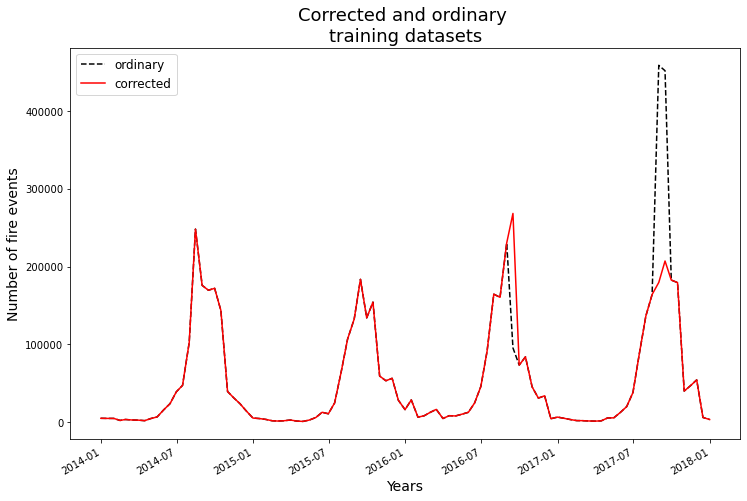

In [20]:
fig, ax = plt.subplots(figsize = (12,8))



ax.plot(y_train, linestyle = '--', color = 'k', label = 'ordinary')
ax.plot(y_train_ac, color = 'red', label = 'corrected')

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_title('Corrected and ordinary \ntraining datasets', fontsize = 18)

plt.gcf().autofmt_xdate()
plt.legend(fontsize = 12)


plt.show()

### Now we make the model with this new dataset where the anomalies were handled properly

In [23]:
model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo,
                                  order = my_order,
                                  seasonal_order = my_sorder,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

model_fit_ac = model_ac.fit()

predictions_ac = model_fit_ac.forecast(len(y_test))

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(y_train_ac.riscofogo, label = 'corrected training set' ,color = 'red', alpha = 0.5, linestyle = '--')
ax.plot(predictions, label = 'predicted value', color = 'k', alpha = 0.6)
ax.plot(predictions_ac, label = 'corrected predicted value', color = 'red', alpha = 0.5)
ax.plot(y_test.riscofogo, label = 'test set')

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.legend(fontsize = 12)
plt.show()

In [52]:
df2 = pd.concat([y_train_ac, y_test])

df2.head()

,riscofogo
datahora,
2013-12-31,4962.0
2014-01-15,4822.0
2014-01-31,4806.0
2014-02-15,2223.0
2014-02-28,3436.0


In [ ]:
df2.tail()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df2.dropna(),lags=59,ax=ax1)
plot_pacf(df2.dropna(),lags=59,ax=ax2)

plt.show()

#(1, 0, 3-4)
#(2, 0, 1 )

In [24]:
new_order = (1, 0, 3)
new_sorder = (2, 1, 1, 24) 


new_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo,
                                  order = new_order,
                                  seasonal_order = new_sorder,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

new_model_fit_ac = new_model_ac.fit() #res

new_predictions_ac = new_model_fit_ac.get_forecast(len(y_test)) #fcast1

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


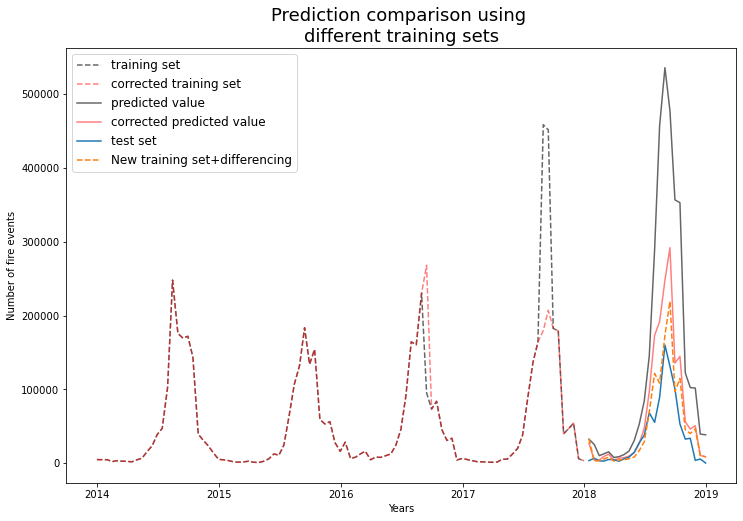

In [25]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(y_train_ac.riscofogo, label = 'corrected training set' ,color = 'red', alpha = 0.5, linestyle = '--')
ax.plot(predictions, label = 'predicted value', color = 'k', alpha = 0.6)
ax.plot(predictions_ac, label = 'corrected predicted value', color = 'red', alpha = 0.5)
ax.plot(y_test.riscofogo, label = 'test set')

ax.plot(new_predictions_ac.predicted_mean, label = 'New training set+differencing', linestyle = '--')

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.legend(fontsize = 12)
plt.show()

So we observe that indeed these last changes increase the model's accuracy.
Let's plot only it to take make it clearer

In [26]:
new_predictions_ac.summary_frame(alpha = 0.10)

riscofogo,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-15,33070.519621,31761.585812,-19172.639999,85313.679241
2018-01-31,2837.906995,31828.817580,-49515.839043,55191.653033
2018-02-15,3485.786246,38792.862244,-60322.793915,67294.366408
2018-02-28,5712.273058,39500.794702,-59260.752375,70685.298491
2018-03-15,8188.778697,39718.263531,-57141.951127,73519.508522
2018-03-31,2769.595571,39785.660429,-62671.992287,68211.183428
2018-04-15,4517.279069,39806.571069,-60958.703730,69993.261868
2018-04-30,4679.165335,39813.077698,-60807.519916,70165.850586
2018-05-15,6047.353584,39815.092461,-59442.645658,71537.352826
2018-05-31,8421.736855,39815.720896,-57069.296070,73912.769781


In [27]:
lower = new_predictions_ac.summary_frame()['mean_ci_lower']
upper = new_predictions_ac.summary_frame()['mean_ci_upper']

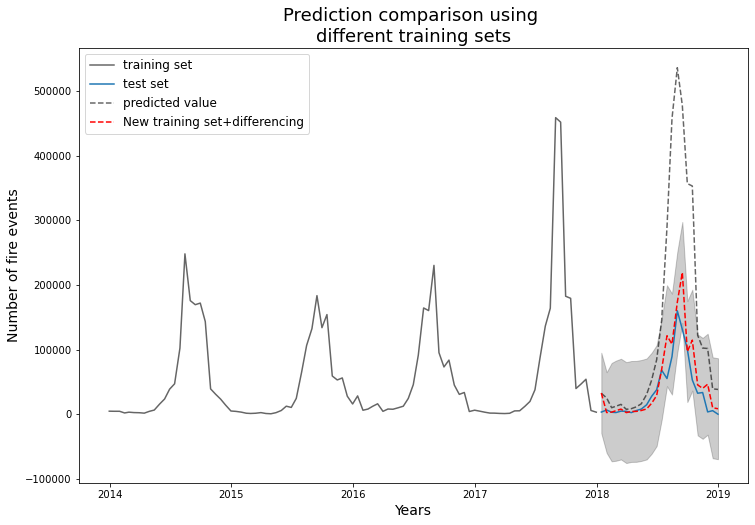

In [28]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6)
ax.plot(y_test.riscofogo, label = 'test set')

ax.plot(predictions, label = 'predicted value', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(new_predictions_ac.predicted_mean, label = 'New training set+differencing', linestyle = '--', color = 'red')


ax.fill_between(new_predictions_ac.summary_frame(alpha=0.10).index,
                lower,
                upper,
                color = 'k', alpha = 0.2)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)

plt.legend(fontsize = 12)
plt.show()

## Quantifying the better prediction

In [30]:
residuals = predictions - y_test.riscofogo
residuals_new = new_predictions_ac.predicted_mean - y_test.riscofogo

MAE = np.mean(abs(residuals/y_test.riscofogo))
MAE_new = np.mean(abs(residuals_new/y_test.riscofogo))

print ('Mean absolute error in percentage : {}'.format(round(100*MAE, 2)))
print ('Mean absolute error in percentage : {}'.format(round(100*MAE_new, 2)))

Mean absolute error in percentage : 897.77
Mean absolute error in percentage : 240.57


In [67]:
## Let's see how much we can improve the results by using rfo for one month
new_rfo_predictions = pd.Series()

for data_end in y_test.index:
    y_data_for = df2[: data_end - relativedelta(months = 1)]
    new_model_rfo = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    new_model_rfo_fit = new_model_rfo.fit()
    pred = new_model_rfo_fit.get_forecast(data_end)
    new_rfo_predictions.loc[data_end] = pred.predicted_mean[data_end]

<ipython-input-67-0a97c2edbc13>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_rfo_predictions = pd.Series()
/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
#new_rfo_predictions, 1month window

residuals = predictions - y_test.riscofogo
residuals_new = new_rfo_predictions - y_test.riscofogo

MAE = np.mean(abs(residuals/y_test.riscofogo))
MAE_new = np.mean(abs(residuals_new/y_test.riscofogo))

print ('Mean absolute error in percentage : {}'.format(round(100*MAE, 2)))
print ('Mean absolute error in percentage : {}'.format(round(100*MAE_new, 2)))

Mean absolute error in percentage : 897.77
Mean absolute error in percentage : 123.32


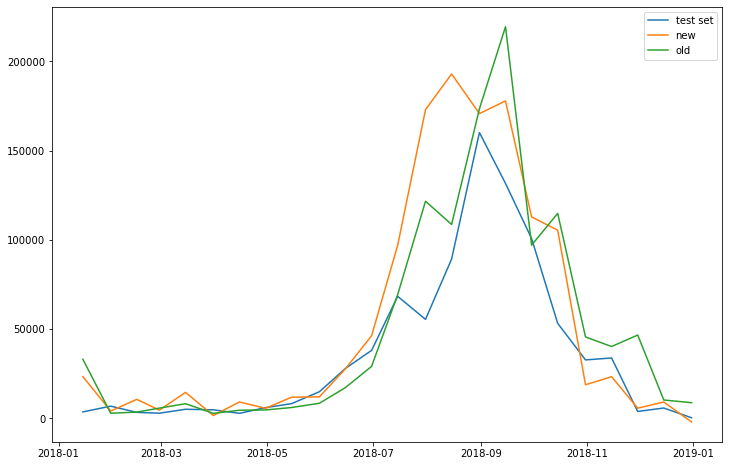

In [69]:
plt.figure(figsize = (12,8))

plt.plot(y_test, label = 'test set')
plt.plot(new_rfo_predictions, label = 'new')
plt.plot(new_predictions_ac.predicted_mean, label = 'old')

plt.legend()
plt.show()

In [82]:
p = range(0,5)
d = range(0,2)
q = range(0,4)

P = range(0,4)
D = range(0,2)
Q = range(0,2)

pdq = list(itertools.product(p, d, q))        ## pdq values
pdqs = [(P, D, Q, 24) for P, D, Q in itertools.product(P, D, Q)]      ## pdq values for the seasonal part

pdqs

[(0, 0, 0, 24),
 (0, 0, 1, 24),
 (0, 1, 0, 24),
 (0, 1, 1, 24),
 (1, 0, 0, 24),
 (1, 0, 1, 24),
 (1, 1, 0, 24),
 (1, 1, 1, 24),
 (2, 0, 0, 24),
 (2, 0, 1, 24),
 (2, 1, 0, 24),
 (2, 1, 1, 24),
 (3, 0, 0, 24),
 (3, 0, 1, 24),
 (3, 1, 0, 24),
 (3, 1, 1, 24)]

In [122]:
## Investigating different models

aic_model_dict = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_aic = sarimax.fit()
            
        print ('Model : {} x {}; AIC : {}'.format(param, seasonal_param, model_aic.aic))
        aic_model_dict[(param, seasonal_param)] = model_aic.aic

Model : (0, 0, 0) x (0, 0, 0, 24); AIC : 2457.4214296169803
Model : (0, 0, 0) x (0, 0, 1, 24); AIC : 1812.5576858909508
Model : (0, 0, 0) x (0, 1, 0, 24); AIC : 1729.7455287206985


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 0) x (0, 1, 1, 24); AIC : 2109.957547011459
Model : (0, 0, 0) x (1, 0, 0, 24); AIC : 1748.1985612445585
Model : (0, 0, 0) x (1, 0, 1, 24); AIC : 1700.9102681270615
Model : (0, 0, 0) x (1, 1, 0, 24); AIC : 1158.6604577107107
Model : (0, 0, 0) x (1, 1, 1, 24); AIC : 1140.5643599350697
Model : (0, 0, 0) x (2, 0, 0, 24); AIC : 1157.317082476037
Model : (0, 0, 0) x (2, 0, 1, 24); AIC : 1259.4506322716343
Model : (0, 0, 0) x (2, 1, 0, 24); AIC : 565.6267885170524
Model : (0, 0, 0) x (2, 1, 1, 24); AIC : 584.6527616145613
Model : (0, 0, 0) x (3, 0, 0, 24); AIC : 556.0325142871577
Model : (0, 0, 0) x (3, 0, 1, 24); AIC : 559.8673995430124
Model : (0, 0, 0) x (3, 1, 0, 24); AIC : 30.93219282929037
Model : (0, 0, 0) x (3, 1, 1, 24); AIC : 32.93219282929037
Model : (0, 0, 1) x (0, 0, 0, 24); AIC : 2372.2864850381648
Model : (0, 0, 1) x (0, 0, 1, 24); AIC : 1756.8517478669592
Model : (0, 0, 1) x (0, 1, 0, 24); AIC : 1672.7881130379083


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 1) x (0, 1, 1, 24); AIC : 1936.2088629125626
Model : (0, 0, 1) x (1, 0, 0, 24); AIC : 1797.905767765762
Model : (0, 0, 1) x (1, 0, 1, 24); AIC : 1749.4417142549132
Model : (0, 0, 1) x (1, 1, 0, 24); AIC : 1152.0147954114823
Model : (0, 0, 1) x (1, 1, 1, 24); AIC : 1107.3561399265889
Model : (0, 0, 1) x (2, 0, 0, 24); AIC : 1210.4554758234813
Model : (0, 0, 1) x (2, 0, 1, 24); AIC : 1212.1439818001077
Model : (0, 0, 1) x (2, 1, 0, 24); AIC : 579.7857509277636
Model : (0, 0, 1) x (2, 1, 1, 24); AIC : 580.8050816733664
Model : (0, 0, 1) x (3, 0, 0, 24); AIC : 621.0535513975594
Model : (0, 0, 1) x (3, 0, 1, 24); AIC : 623.0541928323546
Model : (0, 0, 1) x (3, 1, 0, 24); AIC : 32.6726042490142
Model : (0, 0, 1) x (3, 1, 1, 24); AIC : 34.67260428581551
Model : (0, 0, 2) x (0, 0, 0, 24); AIC : 2366.1720029163184
Model : (0, 0, 2) x (0, 0, 1, 24); AIC : 1747.3202857074732
Model : (0, 0, 2) x (0, 1, 0, 24); AIC : 1651.6672699560577


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 2) x (0, 1, 1, 24); AIC : 1571.8400264719733
Model : (0, 0, 2) x (1, 0, 0, 24); AIC : 1818.4490269900073
Model : (0, 0, 2) x (1, 0, 1, 24); AIC : 1742.667398051993
Model : (0, 0, 2) x (1, 1, 0, 24); AIC : 1152.3336096504906
Model : (0, 0, 2) x (1, 1, 1, 24); AIC : 1085.2743276920696
Model : (0, 0, 2) x (2, 0, 0, 24); AIC : 1218.0058038277193
Model : (0, 0, 2) x (2, 0, 1, 24); AIC : 1219.636641169169
Model : (0, 0, 2) x (2, 1, 0, 24); AIC : 581.5925631528478
Model : (0, 0, 2) x (2, 1, 1, 24); AIC : 582.3020375197602


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 2) x (3, 0, 0, 24); AIC : 622.4816324924291


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 2) x (3, 0, 1, 24); AIC : 621.7111792463966
Model : (0, 0, 2) x (3, 1, 0, 24); AIC : 34.66377181101023
Model : (0, 0, 2) x (3, 1, 1, 24); AIC : 36.66377194795015
Model : (0, 0, 3) x (0, 0, 0, 24); AIC : 2280.862537246682
Model : (0, 0, 3) x (0, 0, 1, 24); AIC : 1730.3075701180494
Model : (0, 0, 3) x (0, 1, 0, 24); AIC : 1629.9822624192968


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (0, 1, 1, 24); AIC : 3893.9369579999757
Model : (0, 0, 3) x (1, 0, 0, 24); AIC : 1833.8714090129681
Model : (0, 0, 3) x (1, 0, 1, 24); AIC : 1678.618319944929
Model : (0, 0, 3) x (1, 1, 0, 24); AIC : 1158.0816288291858
Model : (0, 0, 3) x (1, 1, 1, 24); AIC : 1066.8178695918207
Model : (0, 0, 3) x (2, 0, 0, 24); AIC : 1228.4285187844482
Model : (0, 0, 3) x (2, 0, 1, 24); AIC : 1209.38431443126
Model : (0, 0, 3) x (2, 1, 0, 24); AIC : 582.3845637601893


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (2, 1, 1, 24); AIC : 582.9803783647295
Model : (0, 0, 3) x (3, 0, 0, 24); AIC : 614.4707131509623


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (3, 0, 1, 24); AIC : 616.5072566838911
Model : (0, 0, 3) x (3, 1, 0, 24); AIC : 36.60833700639217
Model : (0, 0, 3) x (3, 1, 1, 24); AIC : 38.60833700782226
Model : (0, 1, 0) x (0, 0, 0, 24); AIC : 2281.9651754050233


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) x (0, 0, 1, 24); AIC : 2899.822225169466
Model : (0, 1, 0) x (0, 1, 0, 24); AIC : 1708.6211861416218
Model : (0, 1, 0) x (0, 1, 1, 24); AIC : 1123.0621298030094
Model : (0, 1, 0) x (1, 0, 0, 24); AIC : 1705.5214981605334


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) x (1, 0, 1, 24); AIC : 2856.6933231211087
Model : (0, 1, 0) x (1, 1, 0, 24); AIC : 1153.9186137646711
Model : (0, 1, 0) x (1, 1, 1, 24); AIC : 1124.7528767453712
Model : (0, 1, 0) x (2, 0, 0, 24); AIC : 1149.5521521837231


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) x (2, 0, 1, 24); AIC : 2150.1610495236946
Model : (0, 1, 0) x (2, 1, 0, 24); AIC : 537.6389702995077
Model : (0, 1, 0) x (2, 1, 1, 24); AIC : 562.7616270392261
Model : (0, 1, 0) x (3, 0, 0, 24); AIC : 538.6211051800876


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) x (3, 0, 1, 24); AIC : 900.3572158785993
Model : (0, 1, 0) x (3, 1, 0, 24); AIC : 8.0
Model : (0, 1, 0) x (3, 1, 1, 24); AIC : 10.0
Model : (0, 1, 1) x (0, 0, 0, 24); AIC : 2260.909771885465


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 1) x (0, 0, 1, 24); AIC : 45668.22024612499
Model : (0, 1, 1) x (0, 1, 0, 24); AIC : 1677.4160269530255
Model : (0, 1, 1) x (0, 1, 1, 24); AIC : 1099.2094192197947
Model : (0, 1, 1) x (1, 0, 0, 24); AIC : 1711.740004924627


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 1) x (1, 0, 1, 24); AIC : 44974.89316264361
Model : (0, 1, 1) x (1, 1, 0, 24); AIC : 1143.514379130552
Model : (0, 1, 1) x (1, 1, 1, 24); AIC : 1098.5464265526382
Model : (0, 1, 1) x (2, 0, 0, 24); AIC : 1145.3449679406667
Model : (0, 1, 1) x (2, 0, 1, 24); AIC : 1854.7440640989553
Model : (0, 1, 1) x (2, 1, 0, 24); AIC : 563.8410314095346
Model : (0, 1, 1) x (2, 1, 1, 24); AIC : 565.840913349558
Model : (0, 1, 1) x (3, 0, 0, 24); AIC : 566.2608242311383
Model : (0, 1, 1) x (3, 0, 1, 24); AIC : 2037.2260431179398
Model : (0, 1, 1) x (3, 1, 0, 24); AIC : 10.0
Model : (0, 1, 1) x (3, 1, 1, 24); AIC : 12.0
Model : (0, 1, 2) x (0, 0, 0, 24); AIC : 2239.1198586242963


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 2) x (0, 0, 1, 24); AIC : 46366.75097120057
Model : (0, 1, 2) x (0, 1, 0, 24); AIC : 1635.8845507241003
Model : (0, 1, 2) x (0, 1, 1, 24); AIC : 1062.2210126113941
Model : (0, 1, 2) x (1, 0, 0, 24); AIC : 1706.9791207631213


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 2) x (1, 0, 1, 24); AIC : 47283.85959475807
Model : (0, 1, 2) x (1, 1, 0, 24); AIC : 1132.4958689935386
Model : (0, 1, 2) x (1, 1, 1, 24); AIC : 1063.9531436992374
Model : (0, 1, 2) x (2, 0, 0, 24); AIC : 1140.3454237451265


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 2) x (2, 0, 1, 24); AIC : 1518.461862300088
Model : (0, 1, 2) x (2, 1, 0, 24); AIC : 560.743174765181
Model : (0, 1, 2) x (2, 1, 1, 24); AIC : 562.3654070046241
Model : (0, 1, 2) x (3, 0, 0, 24); AIC : 568.5278959549981
Model : (0, 1, 2) x (3, 0, 1, 24); AIC : 2040.028010748567
Model : (0, 1, 2) x (3, 1, 0, 24); AIC : 12.0
Model : (0, 1, 2) x (3, 1, 1, 24); AIC : 14.0
Model : (0, 1, 3) x (0, 0, 0, 24); AIC : 2213.5950597163196


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 3) x (0, 0, 1, 24); AIC : 46554.98796489858
Model : (0, 1, 3) x (0, 1, 0, 24); AIC : 1613.1731917002687
Model : (0, 1, 3) x (0, 1, 1, 24); AIC : 1040.6781679137807
Model : (0, 1, 3) x (1, 0, 0, 24); AIC : 1709.0448780738036


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 3) x (1, 0, 1, 24); AIC : 43615.77287367302
Model : (0, 1, 3) x (1, 1, 0, 24); AIC : 1133.855452887005
Model : (0, 1, 3) x (1, 1, 1, 24); AIC : 1042.518082322543
Model : (0, 1, 3) x (2, 0, 0, 24); AIC : 1141.6255383339376


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 3) x (2, 0, 1, 24); AIC : 1740.840610953861
Model : (0, 1, 3) x (2, 1, 0, 24); AIC : 561.8138252948638
Model : (0, 1, 3) x (2, 1, 1, 24); AIC : 563.8002082625693
Model : (0, 1, 3) x (3, 0, 0, 24); AIC : 570.7827734250964
Model : (0, 1, 3) x (3, 0, 1, 24); AIC : 2042.3926409240203
Model : (0, 1, 3) x (3, 1, 0, 24); AIC : 14.0
Model : (0, 1, 3) x (3, 1, 1, 24); AIC : 16.0
Model : (1, 0, 0) x (0, 0, 0, 24); AIC : 2301.9056687197726
Model : (1, 0, 0) x (0, 0, 1, 24); AIC : 1707.3190749782814
Model : (1, 0, 0) x (0, 1, 0, 24); AIC : 1708.5173550798468


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 0) x (0, 1, 1, 24); AIC : 2073.299563696958
Model : (1, 0, 0) x (1, 0, 0, 24); AIC : 1704.5155206700074
Model : (1, 0, 0) x (1, 0, 1, 24); AIC : 1699.2377394896207
Model : (1, 0, 0) x (1, 1, 0, 24); AIC : 1135.6836744307266
Model : (1, 0, 0) x (1, 1, 1, 24); AIC : 1137.2587882785251
Model : (1, 0, 0) x (2, 0, 0, 24); AIC : 1139.9258907239991
Model : (1, 0, 0) x (2, 0, 1, 24); AIC : 1139.7772775322028
Model : (1, 0, 0) x (2, 1, 0, 24); AIC : 557.0097753680893
Model : (1, 0, 0) x (2, 1, 1, 24); AIC : 558.3349087443173
Model : (1, 0, 0) x (3, 0, 0, 24); AIC : 563.6555279337322
Model : (1, 0, 0) x (3, 0, 1, 24); AIC : 565.6535223263912
Model : (1, 0, 0) x (3, 1, 0, 24); AIC : 10.0
Model : (1, 0, 0) x (3, 1, 1, 24); AIC : 12.0
Model : (1, 0, 1) x (0, 0, 0, 24); AIC : 2280.513773948463
Model : (1, 0, 1) x (0, 0, 1, 24); AIC : 1686.4713213805026
Model : (1, 0, 1) x (0, 1, 0, 24); AIC : 1674.6669617930024


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 1) x (0, 1, 1, 24); AIC : 1908.9713704244964
Model : (1, 0, 1) x (1, 0, 0, 24); AIC : 1701.9954844812669
Model : (1, 0, 1) x (1, 0, 1, 24); AIC : 1674.0418747418578
Model : (1, 0, 1) x (1, 1, 0, 24); AIC : 1129.8588870559133
Model : (1, 0, 1) x (1, 1, 1, 24); AIC : 1108.243489529318
Model : (1, 0, 1) x (2, 0, 0, 24); AIC : 1137.088353187084
Model : (1, 0, 1) x (2, 0, 1, 24); AIC : 1137.833031850551
Model : (1, 0, 1) x (2, 1, 0, 24); AIC : 558.9225883135177
Model : (1, 0, 1) x (2, 1, 1, 24); AIC : 560.526288031684
Model : (1, 0, 1) x (3, 0, 0, 24); AIC : 566.0020211657169
Model : (1, 0, 1) x (3, 0, 1, 24); AIC : 568.00159971688
Model : (1, 0, 1) x (3, 1, 0, 24); AIC : 12.0
Model : (1, 0, 1) x (3, 1, 1, 24); AIC : 14.0
Model : (1, 0, 2) x (0, 0, 0, 24); AIC : 2258.110408624542
Model : (1, 0, 2) x (0, 0, 1, 24); AIC : 1665.668339652915
Model : (1, 0, 2) x (0, 1, 0, 24); AIC : 1653.1033715483577


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 2) x (0, 1, 1, 24); AIC : 1880.9302015824562
Model : (1, 0, 2) x (1, 0, 0, 24); AIC : 1703.6186510791015
Model : (1, 0, 2) x (1, 0, 1, 24); AIC : 1653.5781063231714
Model : (1, 0, 2) x (1, 1, 0, 24); AIC : 1130.9598329208338
Model : (1, 0, 2) x (1, 1, 1, 24); AIC : 1086.5997583443193
Model : (1, 0, 2) x (2, 0, 0, 24); AIC : 1139.1210225266136
Model : (1, 0, 2) x (2, 0, 1, 24); AIC : 1139.7710320819706
Model : (1, 0, 2) x (2, 1, 0, 24); AIC : 559.5631087058762


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 2) x (2, 1, 1, 24); AIC : 560.1246367655051
Model : (1, 0, 2) x (3, 0, 0, 24); AIC : 568.0761928050666
Model : (1, 0, 2) x (3, 0, 1, 24); AIC : 570.0769528269313
Model : (1, 0, 2) x (3, 1, 0, 24); AIC : 14.0
Model : (1, 0, 2) x (3, 1, 1, 24); AIC : 16.0
Model : (1, 0, 3) x (0, 0, 0, 24); AIC : 2229.5914891262073
Model : (1, 0, 3) x (0, 0, 1, 24); AIC : 1640.6544971318951
Model : (1, 0, 3) x (0, 1, 0, 24); AIC : 1630.3702867129587


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (0, 1, 1, 24); AIC : 1682.4426478284697
Model : (1, 0, 3) x (1, 0, 0, 24); AIC : 1702.772965136977
Model : (1, 0, 3) x (1, 0, 1, 24); AIC : 1630.1505978572557
Model : (1, 0, 3) x (1, 1, 0, 24); AIC : 1130.8387378795844
Model : (1, 0, 3) x (1, 1, 1, 24); AIC : 1063.5820391017712
Model : (1, 0, 3) x (2, 0, 0, 24); AIC : 1139.5642176197612
Model : (1, 0, 3) x (2, 0, 1, 24); AIC : 1140.176249191467
Model : (1, 0, 3) x (2, 1, 0, 24); AIC : 560.4815384133136


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 1, 1, 24); AIC : 561.7197949016956
Model : (1, 0, 3) x (3, 0, 0, 24); AIC : 569.2435915848881
Model : (1, 0, 3) x (3, 0, 1, 24); AIC : 571.2466444658285
Model : (1, 0, 3) x (3, 1, 0, 24); AIC : 16.0
Model : (1, 0, 3) x (3, 1, 1, 24); AIC : 18.0
Model : (1, 1, 0) x (0, 0, 0, 24); AIC : 2283.8823018932912
Model : (1, 1, 0) x (0, 0, 1, 24); AIC : 47680.68925948472
Model : (1, 1, 0) x (0, 1, 0, 24); AIC : 1705.167222686131
Model : (1, 1, 0) x (0, 1, 1, 24); AIC : 1124.1083000121391
Model : (1, 1, 0) x (1, 0, 0, 24); AIC : 1688.3723486786514
Model : (1, 1, 0) x (1, 0, 1, 24); AIC : 47619.38083792559
Model : (1, 1, 0) x (1, 1, 0, 24); AIC : 1130.8783851621063
Model : (1, 1, 0) x (1, 1, 1, 24); AIC : 1126.0740022886089
Model : (1, 1, 0) x (2, 0, 0, 24); AIC : 1128.783604720889


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 0) x (2, 0, 1, 24); AIC : 1807.0348921679551
Model : (1, 1, 0) x (2, 1, 0, 24); AIC : 539.9111804064543
Model : (1, 1, 0) x (2, 1, 1, 24); AIC : 541.8750095623278
Model : (1, 1, 0) x (3, 0, 0, 24); AIC : 542.5982481342295
Model : (1, 1, 0) x (3, 0, 1, 24); AIC : 1952.0919395303981
Model : (1, 1, 0) x (3, 1, 0, 24); AIC : 10.0
Model : (1, 1, 0) x (3, 1, 1, 24); AIC : 12.0
Model : (1, 1, 1) x (0, 0, 0, 24); AIC : 2256.5312054944707
Model : (1, 1, 1) x (0, 0, 1, 24); AIC : 47455.427909626575
Model : (1, 1, 1) x (0, 1, 0, 24); AIC : 1668.1277809298178
Model : (1, 1, 1) x (0, 1, 1, 24); AIC : 1096.1867957743543
Model : (1, 1, 1) x (1, 0, 0, 24); AIC : 1683.934207632702
Model : (1, 1, 1) x (1, 0, 1, 24); AIC : 171614.74047804732
Model : (1, 1, 1) x (1, 1, 0, 24); AIC : 1120.5090137782936
Model : (1, 1, 1) x (1, 1, 1, 24); AIC : 1097.5181312972163
Model : (1, 1, 1) x (2, 0, 0, 24); AIC : 1120.5971913507803


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 1) x (2, 0, 1, 24); AIC : 511.0078891792902
Model : (1, 1, 1) x (2, 1, 0, 24); AIC : 542.5763573727918
Model : (1, 1, 1) x (2, 1, 1, 24); AIC : 544.576264250131
Model : (1, 1, 1) x (3, 0, 0, 24); AIC : 544.3120477785659


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 1) x (3, 0, 1, 24); AIC : 14.0
Model : (1, 1, 1) x (3, 1, 0, 24); AIC : 12.0
Model : (1, 1, 1) x (3, 1, 1, 24); AIC : 14.0
Model : (1, 1, 2) x (0, 0, 0, 24); AIC : 2239.793798521718


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (0, 0, 1, 24); AIC : 44475.63029120551
Model : (1, 1, 2) x (0, 1, 0, 24); AIC : 1636.5779522252828
Model : (1, 1, 2) x (0, 1, 1, 24); AIC : 1062.9911062578421
Model : (1, 1, 2) x (1, 0, 0, 24); AIC : 1682.6080363338656
Model : (1, 1, 2) x (1, 0, 1, 24); AIC : 45540.59287355331
Model : (1, 1, 2) x (1, 1, 0, 24); AIC : 1108.8346202866328
Model : (1, 1, 2) x (1, 1, 1, 24); AIC : 1064.0779491639023
Model : (1, 1, 2) x (2, 0, 0, 24); AIC : 1117.7314219064813


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (2, 0, 1, 24); AIC : 1795.7886978395504


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (2, 1, 0, 24); AIC : 538.2909674795136
Model : (1, 1, 2) x (2, 1, 1, 24); AIC : 540.0525931342486
Model : (1, 1, 2) x (3, 0, 0, 24); AIC : 547.1907202360871
Model : (1, 1, 2) x (3, 0, 1, 24); AIC : 1957.434467605326
Model : (1, 1, 2) x (3, 1, 0, 24); AIC : 14.0
Model : (1, 1, 2) x (3, 1, 1, 24); AIC : 16.0
Model : (1, 1, 3) x (0, 0, 0, 24); AIC : 2215.3552925961817


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (0, 0, 1, 24); AIC : 45211.5863827403
Model : (1, 1, 3) x (0, 1, 0, 24); AIC : 1615.14972349611
Model : (1, 1, 3) x (0, 1, 1, 24); AIC : 1042.542445993487
Model : (1, 1, 3) x (1, 0, 0, 24); AIC : 1687.0184272207555


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (1, 0, 1, 24); AIC : 45132.3337541437
Model : (1, 1, 3) x (1, 1, 0, 24); AIC : 1113.0310318595893
Model : (1, 1, 3) x (1, 1, 1, 24); AIC : 1043.739749574966
Model : (1, 1, 3) x (2, 0, 0, 24); AIC : 1119.3338478325702


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (2, 0, 1, 24); AIC : 1643.594889742636
Model : (1, 1, 3) x (2, 1, 0, 24); AIC : 540.9438009002862


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (2, 1, 1, 24); AIC : 545.1895926042563
Model : (1, 1, 3) x (3, 0, 0, 24); AIC : 549.0106420738128
Model : (1, 1, 3) x (3, 0, 1, 24); AIC : 1959.3212833287623
Model : (1, 1, 3) x (3, 1, 0, 24); AIC : 16.0
Model : (1, 1, 3) x (3, 1, 1, 24); AIC : 18.0
Model : (2, 0, 0) x (0, 0, 0, 24); AIC : 2280.3421016083266
Model : (2, 0, 0) x (0, 0, 1, 24); AIC : 1708.9547460965
Model : (2, 0, 0) x (0, 1, 0, 24); AIC : 1686.3895693025424


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 0) x (0, 1, 1, 24); AIC : 1686.4351859610451
Model : (2, 0, 0) x (1, 0, 0, 24); AIC : 1683.654967785988
Model : (2, 0, 0) x (1, 0, 1, 24); AIC : 1678.1797630080055
Model : (2, 0, 0) x (1, 1, 0, 24); AIC : 1112.8590478085785
Model : (2, 0, 0) x (1, 1, 1, 24); AIC : 1114.8081206978784
Model : (2, 0, 0) x (2, 0, 0, 24); AIC : 1115.7657972910495
Model : (2, 0, 0) x (2, 0, 1, 24); AIC : 1115.3369859511868
Model : (2, 0, 0) x (2, 1, 0, 24); AIC : 535.6689423767009
Model : (2, 0, 0) x (2, 1, 1, 24); AIC : 537.645578497371
Model : (2, 0, 0) x (3, 0, 0, 24); AIC : 542.2699655400781
Model : (2, 0, 0) x (3, 0, 1, 24); AIC : 544.269381342694
Model : (2, 0, 0) x (3, 1, 0, 24); AIC : 12.0
Model : (2, 0, 0) x (3, 1, 1, 24); AIC : 14.0
Model : (2, 0, 1) x (0, 0, 0, 24); AIC : 2282.2424282890574
Model : (2, 0, 1) x (0, 0, 1, 24); AIC : 1687.3449660787312
Model : (2, 0, 1) x (0, 1, 0, 24); AIC : 1683.1055062065668


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (0, 1, 1, 24); AIC : 10.0
Model : (2, 0, 1) x (1, 0, 0, 24); AIC : 1684.1565429682807
Model : (2, 0, 1) x (1, 0, 1, 24); AIC : 1679.0623696760138
Model : (2, 0, 1) x (1, 1, 0, 24); AIC : 1111.5793344916447
Model : (2, 0, 1) x (1, 1, 1, 24); AIC : 1113.4482219298375
Model : (2, 0, 1) x (2, 0, 0, 24); AIC : 1120.418458525735
Model : (2, 0, 1) x (2, 0, 1, 24); AIC : 1119.986754509005
Model : (2, 0, 1) x (2, 1, 0, 24); AIC : 536.3808950066687


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 1, 1, 24); AIC : 536.7780792529151
Model : (2, 0, 1) x (3, 0, 0, 24); AIC : 543.749147153674


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (3, 0, 1, 24); AIC : 545.8744389425267
Model : (2, 0, 1) x (3, 1, 0, 24); AIC : 14.0
Model : (2, 0, 1) x (3, 1, 1, 24); AIC : 16.0
Model : (2, 0, 2) x (0, 0, 0, 24); AIC : 2254.846884829902
Model : (2, 0, 2) x (0, 0, 1, 24); AIC : 1667.0738822318767
Model : (2, 0, 2) x (0, 1, 0, 24); AIC : 1654.0747729204986


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (0, 1, 1, 24); AIC : 2067.798732056703
Model : (2, 0, 2) x (1, 0, 0, 24); AIC : 1681.1543614974148
Model : (2, 0, 2) x (1, 0, 1, 24); AIC : 1653.628501035053
Model : (2, 0, 2) x (1, 1, 0, 24); AIC : 1108.2976284616661
Model : (2, 0, 2) x (1, 1, 1, 24); AIC : 1086.370140483544
Model : (2, 0, 2) x (2, 0, 0, 24); AIC : 1117.1886907601483


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 1, 24); AIC : 1117.7564969121736
Model : (2, 0, 2) x (2, 1, 0, 24); AIC : 537.9271321368251


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 1, 1, 24); AIC : 538.7195988639912
Model : (2, 0, 2) x (3, 0, 0, 24); AIC : 546.1673073328246


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (3, 0, 1, 24); AIC : 548.1663135825726
Model : (2, 0, 2) x (3, 1, 0, 24); AIC : 16.0
Model : (2, 0, 2) x (3, 1, 1, 24); AIC : 18.0
Model : (2, 0, 3) x (0, 0, 0, 24); AIC : 2230.397699029349
Model : (2, 0, 3) x (0, 0, 1, 24); AIC : 1642.3464042457304
Model : (2, 0, 3) x (0, 1, 0, 24); AIC : 1627.9039076009165


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (0, 1, 1, 24); AIC : 1621.4784655048377
Model : (2, 0, 3) x (1, 0, 0, 24); AIC : 1680.536626680199
Model : (2, 0, 3) x (1, 0, 1, 24); AIC : 1629.8534945034646
Model : (2, 0, 3) x (1, 1, 0, 24); AIC : 1107.7469348678671
Model : (2, 0, 3) x (1, 1, 1, 24); AIC : 1063.7442526814325
Model : (2, 0, 3) x (2, 0, 0, 24); AIC : 1116.8624850176896
Model : (2, 0, 3) x (2, 0, 1, 24); AIC : 1117.5979177032812
Model : (2, 0, 3) x (2, 1, 0, 24); AIC : 539.2077803188555


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 1, 1, 24); AIC : 543.0917486035697
Model : (2, 0, 3) x (3, 0, 0, 24); AIC : 547.8431262556727


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (3, 0, 1, 24); AIC : 549.8452830667051
Model : (2, 0, 3) x (3, 1, 0, 24); AIC : 18.0
Model : (2, 0, 3) x (3, 1, 1, 24); AIC : 20.0
Model : (2, 1, 0) x (0, 0, 0, 24); AIC : 2262.1022638975974
Model : (2, 1, 0) x (0, 0, 1, 24); AIC : 47598.797342431564
Model : (2, 1, 0) x (0, 1, 0, 24); AIC : 1664.7589990397069
Model : (2, 1, 0) x (0, 1, 1, 24); AIC : 1113.7236506591971
Model : (2, 1, 0) x (1, 0, 0, 24); AIC : 1661.532971145263
Model : (2, 1, 0) x (1, 0, 1, 24); AIC : 47454.05474675784
Model : (2, 1, 0) x (1, 1, 0, 24); AIC : 1088.077839793866
Model : (2, 1, 0) x (1, 1, 1, 24); AIC : 1089.7020197390113
Model : (2, 1, 0) x (2, 0, 0, 24); AIC : 1094.6197761523579


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 0) x (2, 0, 1, 24); AIC : 1956.437171245059
Model : (2, 1, 0) x (2, 1, 0, 24); AIC : 514.0270834191531
Model : (2, 1, 0) x (2, 1, 1, 24); AIC : 515.8392561826779
Model : (2, 1, 0) x (3, 0, 0, 24); AIC : 521.349104306136
Model : (2, 1, 0) x (3, 0, 1, 24); AIC : 1869.7913065799053
Model : (2, 1, 0) x (3, 1, 0, 24); AIC : 12.0
Model : (2, 1, 0) x (3, 1, 1, 24); AIC : 14.0
Model : (2, 1, 1) x (0, 0, 0, 24); AIC : 2263.632485209872


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (0, 0, 1, 24); AIC : 153076.2228577589
Model : (2, 1, 1) x (0, 1, 0, 24); AIC : 1660.3020177858505
Model : (2, 1, 1) x (0, 1, 1, 24); AIC : 1089.0502784867294
Model : (2, 1, 1) x (1, 0, 0, 24); AIC : 1659.122728697585


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (1, 0, 1, 24); AIC : 153538.15819149846
Model : (2, 1, 1) x (1, 1, 0, 24); AIC : 1090.083120693843
Model : (2, 1, 1) x (1, 1, 1, 24); AIC : 1090.6217549679266
Model : (2, 1, 1) x (2, 0, 0, 24); AIC : 1096.315039216063
Model : (2, 1, 1) x (2, 0, 1, 24); AIC : 768.3948391321936
Model : (2, 1, 1) x (2, 1, 0, 24); AIC : 515.8830092421871
Model : (2, 1, 1) x (2, 1, 1, 24); AIC : 517.8795008121544
Model : (2, 1, 1) x (3, 0, 0, 24); AIC : 522.8612722109086


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (3, 0, 1, 24); AIC : 16.0
Model : (2, 1, 1) x (3, 1, 0, 24); AIC : 14.0
Model : (2, 1, 1) x (3, 1, 1, 24); AIC : 16.0
Model : (2, 1, 2) x (0, 0, 0, 24); AIC : 2237.7303901392434


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (0, 0, 1, 24); AIC : 47196.05887682395
Model : (2, 1, 2) x (0, 1, 0, 24); AIC : 1638.0085662324814
Model : (2, 1, 2) x (0, 1, 1, 24); AIC : 1067.0391705198322
Model : (2, 1, 2) x (1, 0, 0, 24); AIC : 1662.707432851451


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (1, 0, 1, 24); AIC : 45372.532737209774
Model : (2, 1, 2) x (1, 1, 0, 24); AIC : 1087.8762701979963
Model : (2, 1, 2) x (1, 1, 1, 24); AIC : 1066.8102918522236
Model : (2, 1, 2) x (2, 0, 0, 24); AIC : 1095.091113628676


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (2, 0, 1, 24); AIC : 1490.629027896965
Model : (2, 1, 2) x (2, 1, 0, 24); AIC : 517.0381151736381


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (2, 1, 1, 24); AIC : 518.6105414343426
Model : (2, 1, 2) x (3, 0, 0, 24); AIC : 525.7775207245518
Model : (2, 1, 2) x (3, 0, 1, 24); AIC : 1874.919136932613
Model : (2, 1, 2) x (3, 1, 0, 24); AIC : 16.0
Model : (2, 1, 2) x (3, 1, 1, 24); AIC : 18.0
Model : (2, 1, 3) x (0, 0, 0, 24); AIC : 2216.025645982016


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (0, 0, 1, 24); AIC : 44241.901567637644
Model : (2, 1, 3) x (0, 1, 0, 24); AIC : 1615.438462906847
Model : (2, 1, 3) x (0, 1, 1, 24); AIC : 1043.2780054704217
Model : (2, 1, 3) x (1, 0, 0, 24); AIC : 1663.882403898764


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (1, 0, 1, 24); AIC : 45293.714942882376
Model : (2, 1, 3) x (1, 1, 0, 24); AIC : 1085.8673821166376
Model : (2, 1, 3) x (1, 1, 1, 24); AIC : 1041.0159439031506
Model : (2, 1, 3) x (2, 0, 0, 24); AIC : 1095.5304747201276


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (2, 0, 1, 24); AIC : 1835.7382896647678
Model : (2, 1, 3) x (2, 1, 0, 24); AIC : 519.9734063106212


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (2, 1, 1, 24); AIC : 521.3472712746766


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (3, 0, 0, 24); AIC : 527.3995037077766
Model : (2, 1, 3) x (3, 0, 1, 24); AIC : 1876.7681012135963
Model : (2, 1, 3) x (3, 1, 0, 24); AIC : 18.0
Model : (2, 1, 3) x (3, 1, 1, 24); AIC : 20.0
Model : (3, 0, 0) x (0, 0, 0, 24); AIC : 2257.0520402056723
Model : (3, 0, 0) x (0, 0, 1, 24); AIC : 1710.5971766675732
Model : (3, 0, 0) x (0, 1, 0, 24); AIC : 1658.1753909184365


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 0) x (0, 1, 1, 24); AIC : 1842.8458888080781
Model : (3, 0, 0) x (1, 0, 0, 24); AIC : 1658.0588574442509
Model : (3, 0, 0) x (1, 0, 1, 24); AIC : 1652.2550154269302
Model : (3, 0, 0) x (1, 1, 0, 24); AIC : 1083.8593806819426
Model : (3, 0, 0) x (1, 1, 1, 24); AIC : 1085.7884452821233
Model : (3, 0, 0) x (2, 0, 0, 24); AIC : 1090.729805701651
Model : (3, 0, 0) x (2, 0, 1, 24); AIC : 1091.4504192219774
Model : (3, 0, 0) x (2, 1, 0, 24); AIC : 513.6035443015476
Model : (3, 0, 0) x (2, 1, 1, 24); AIC : 514.3298748609011
Model : (3, 0, 0) x (3, 0, 0, 24); AIC : 520.976434295621


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 0) x (3, 0, 1, 24); AIC : 522.9751365224773
Model : (3, 0, 0) x (3, 1, 0, 24); AIC : 14.0
Model : (3, 0, 0) x (3, 1, 1, 24); AIC : 16.0
Model : (3, 0, 1) x (0, 0, 0, 24); AIC : 2256.560060579462
Model : (3, 0, 1) x (0, 0, 1, 24); AIC : 1687.9088847393105
Model : (3, 0, 1) x (0, 1, 0, 24); AIC : 1650.9882270596927


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 1) x (0, 1, 1, 24); AIC : 1797.7278837636693
Model : (3, 0, 1) x (1, 0, 0, 24); AIC : 1654.743252707264
Model : (3, 0, 1) x (1, 0, 1, 24); AIC : 1651.6305690377244
Model : (3, 0, 1) x (1, 1, 0, 24); AIC : 1083.696822325875
Model : (3, 0, 1) x (1, 1, 1, 24); AIC : 1085.4481969661822
Model : (3, 0, 1) x (2, 0, 0, 24); AIC : 1091.681264145552
Model : (3, 0, 1) x (2, 0, 1, 24); AIC : 1092.4556610209625
Model : (3, 0, 1) x (2, 1, 0, 24); AIC : 515.6004735888923


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 1) x (2, 1, 1, 24); AIC : 515.9683763564246
Model : (3, 0, 1) x (3, 0, 0, 24); AIC : 522.7012677113503
Model : (3, 0, 1) x (3, 0, 1, 24); AIC : 524.6970115509798
Model : (3, 0, 1) x (3, 1, 0, 24); AIC : 16.0
Model : (3, 0, 1) x (3, 1, 1, 24); AIC : 18.0
Model : (3, 0, 2) x (0, 0, 0, 24); AIC : 2254.447126873701
Model : (3, 0, 2) x (0, 0, 1, 24); AIC : 1668.4742463884259
Model : (3, 0, 2) x (0, 1, 0, 24); AIC : 1652.2989641924191


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (0, 1, 1, 24); AIC : 1776.746763141011
Model : (3, 0, 2) x (1, 0, 0, 24); AIC : 1662.473441996185
Model : (3, 0, 2) x (1, 0, 1, 24); AIC : 1654.1129317298366
Model : (3, 0, 2) x (1, 1, 0, 24); AIC : 1085.0762991333013
Model : (3, 0, 2) x (1, 1, 1, 24); AIC : 1086.8272415040026
Model : (3, 0, 2) x (2, 0, 0, 24); AIC : 1093.8960300716233
Model : (3, 0, 2) x (2, 0, 1, 24); AIC : 1094.354900809612
Model : (3, 0, 2) x (2, 1, 0, 24); AIC : 517.0110397205215


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (2, 1, 1, 24); AIC : 517.2218120485713
Model : (3, 0, 2) x (3, 0, 0, 24); AIC : 525.044413277594


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (3, 0, 1, 24); AIC : 527.0449309606853
Model : (3, 0, 2) x (3, 1, 0, 24); AIC : 18.0
Model : (3, 0, 2) x (3, 1, 1, 24); AIC : 20.0
Model : (3, 0, 3) x (0, 0, 0, 24); AIC : 2232.368127199502
Model : (3, 0, 3) x (0, 0, 1, 24); AIC : 1644.3023578352913
Model : (3, 0, 3) x (0, 1, 0, 24); AIC : 1631.7125801460147


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (0, 1, 1, 24); AIC : 1860.4632279367195
Model : (3, 0, 3) x (1, 0, 0, 24); AIC : 1658.8398456046996
Model : (3, 0, 3) x (1, 0, 1, 24); AIC : 1632.7117299556348
Model : (3, 0, 3) x (1, 1, 0, 24); AIC : 1086.9427744307004
Model : (3, 0, 3) x (1, 1, 1, 24); AIC : 1065.85896915021
Model : (3, 0, 3) x (2, 0, 0, 24); AIC : 1095.6585233375476
Model : (3, 0, 3) x (2, 0, 1, 24); AIC : 1096.5103872820698


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (2, 1, 0, 24); AIC : 518.2274076899034


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (2, 1, 1, 24); AIC : 520.546490388489


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (3, 0, 0, 24); AIC : 526.7453945008731


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (3, 0, 1, 24); AIC : 528.7372647845777
Model : (3, 0, 3) x (3, 1, 0, 24); AIC : 20.0
Model : (3, 0, 3) x (3, 1, 1, 24); AIC : 22.0
Model : (3, 1, 0) x (0, 0, 0, 24); AIC : 2238.962108600417
Model : (3, 1, 0) x (0, 0, 1, 24); AIC : 46626.029865362616
Model : (3, 1, 0) x (0, 1, 0, 24); AIC : 1642.2441933020625
Model : (3, 1, 0) x (0, 1, 1, 24); AIC : 1114.7024636550227
Model : (3, 1, 0) x (1, 0, 0, 24); AIC : 1638.470993075702
Model : (3, 1, 0) x (1, 0, 1, 24); AIC : 46415.050990797805
Model : (3, 1, 0) x (1, 1, 0, 24); AIC : 1067.2672450233465
Model : (3, 1, 0) x (1, 1, 1, 24); AIC : 1068.8848292747532
Model : (3, 1, 0) x (2, 0, 0, 24); AIC : 1073.3811241087376


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 0) x (2, 0, 1, 24); AIC : 1660.9457037792622
Model : (3, 1, 0) x (2, 1, 0, 24); AIC : 493.0622078232857
Model : (3, 1, 0) x (2, 1, 1, 24); AIC : 494.8943907958108
Model : (3, 1, 0) x (3, 0, 0, 24); AIC : 500.08928479649546
Model : (3, 1, 0) x (3, 0, 1, 24); AIC : 1787.1799475168311
Model : (3, 1, 0) x (3, 1, 0, 24); AIC : 14.0
Model : (3, 1, 0) x (3, 1, 1, 24); AIC : 16.0
Model : (3, 1, 1) x (0, 0, 0, 24); AIC : 2240.6382301831477
Model : (3, 1, 1) x (0, 0, 1, 24); AIC : 46550.95353917122
Model : (3, 1, 1) x (0, 1, 0, 24); AIC : 1638.9761075386905
Model : (3, 1, 1) x (0, 1, 1, 24); AIC : 1090.6567695847325
Model : (3, 1, 1) x (1, 0, 0, 24); AIC : 1637.949122150382


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 1) x (1, 0, 1, 24); AIC : 46098.71410963198
Model : (3, 1, 1) x (1, 1, 0, 24); AIC : 1065.643184664954
Model : (3, 1, 1) x (1, 1, 1, 24); AIC : 1067.5208283780514
Model : (3, 1, 1) x (2, 0, 0, 24); AIC : 1072.464468750893


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 1) x (2, 0, 1, 24); AIC : 2016.5231580080335
Model : (3, 1, 1) x (2, 1, 0, 24); AIC : 495.1510281170009
Model : (3, 1, 1) x (2, 1, 1, 24); AIC : 497.0442320003417
Model : (3, 1, 1) x (3, 0, 0, 24); AIC : 502.06564299809315
Model : (3, 1, 1) x (3, 0, 1, 24); AIC : 1789.4067428053058
Model : (3, 1, 1) x (3, 1, 0, 24); AIC : 16.0
Model : (3, 1, 1) x (3, 1, 1, 24); AIC : 18.0
Model : (3, 1, 2) x (0, 0, 0, 24); AIC : 2239.1856620448852
Model : (3, 1, 2) x (0, 0, 1, 24); AIC : 46011.439410020466
Model : (3, 1, 2) x (0, 1, 0, 24); AIC : 1630.652064581556
Model : (3, 1, 2) x (0, 1, 1, 24); AIC : 1064.3087066473997
Model : (3, 1, 2) x (1, 0, 0, 24); AIC : 1636.4443568653292
Model : (3, 1, 2) x (1, 0, 1, 24); AIC : 45969.468761950346
Model : (3, 1, 2) x (1, 1, 0, 24); AIC : 1065.1704949833274
Model : (3, 1, 2) x (1, 1, 1, 24); AIC : 1065.0133025538698
Model : (3, 1, 2) x (2, 0, 0, 24); AIC : 1072.8957555955456


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 2) x (2, 0, 1, 24); AIC : 1629.7651866144754
Model : (3, 1, 2) x (2, 1, 0, 24); AIC : 495.9491730678565
Model : (3, 1, 2) x (2, 1, 1, 24); AIC : 497.31934908154017
Model : (3, 1, 2) x (3, 0, 0, 24); AIC : 504.3275774074601
Model : (3, 1, 2) x (3, 0, 1, 24); AIC : 1792.0927220771061
Model : (3, 1, 2) x (3, 1, 0, 24); AIC : 18.0
Model : (3, 1, 2) x (3, 1, 1, 24); AIC : 20.0
Model : (3, 1, 3) x (0, 0, 0, 24); AIC : 2217.8959516127475


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (0, 0, 1, 24); AIC : 44054.385489976936
Model : (3, 1, 3) x (0, 1, 0, 24); AIC : 1610.0095067179439
Model : (3, 1, 3) x (0, 1, 1, 24); AIC : 1043.6335297894736
Model : (3, 1, 3) x (1, 0, 0, 24); AIC : 1638.604113319982


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (1, 0, 1, 24); AIC : 44679.957256178
Model : (3, 1, 3) x (1, 1, 0, 24); AIC : 1066.0447760337654
Model : (3, 1, 3) x (1, 1, 1, 24); AIC : 1044.5303860548445


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 0, 0, 24); AIC : 1075.1831593155694


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 0, 1, 24); AIC : 1875.4350102631295
Model : (3, 1, 3) x (2, 1, 0, 24); AIC : 497.98340626107324


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 1, 1, 24); AIC : 499.9717221342804


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (3, 0, 0, 24); AIC : 505.95103828986583
Model : (3, 1, 3) x (3, 0, 1, 24); AIC : 1794.3368700044157
Model : (3, 1, 3) x (3, 1, 0, 24); AIC : 20.0
Model : (3, 1, 3) x (3, 1, 1, 24); AIC : 22.0
Model : (4, 0, 0) x (0, 0, 0, 24); AIC : 2230.569547112773
Model : (4, 0, 0) x (0, 0, 1, 24); AIC : 1708.150937284748
Model : (4, 0, 0) x (0, 1, 0, 24); AIC : 1630.4665500354922


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 0) x (0, 1, 1, 24); AIC : 1963.8208153328185
Model : (4, 0, 0) x (1, 0, 0, 24); AIC : 1631.9427140555645
Model : (4, 0, 0) x (1, 0, 1, 24); AIC : 1627.9216314077191
Model : (4, 0, 0) x (1, 1, 0, 24); AIC : 1061.6349176372676
Model : (4, 0, 0) x (1, 1, 1, 24); AIC : 1063.5420222039072
Model : (4, 0, 0) x (2, 0, 0, 24); AIC : 1068.2127689088131
Model : (4, 0, 0) x (2, 0, 1, 24); AIC : 1068.9289706719358
Model : (4, 0, 0) x (2, 1, 0, 24); AIC : 491.0734496867454
Model : (4, 0, 0) x (2, 1, 1, 24); AIC : 492.9962937856967
Model : (4, 0, 0) x (3, 0, 0, 24); AIC : 498.878037249759


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 0) x (3, 0, 1, 24); AIC : 500.88867582619645
Model : (4, 0, 0) x (3, 1, 0, 24); AIC : 16.0
Model : (4, 0, 0) x (3, 1, 1, 24); AIC : 18.0
Model : (4, 0, 1) x (0, 0, 0, 24); AIC : 2232.574638136736
Model : (4, 0, 1) x (0, 0, 1, 24); AIC : 1686.942428786576
Model : (4, 0, 1) x (0, 1, 0, 24); AIC : 1629.2188410449842


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (0, 1, 1, 24); AIC : 1849.9081780686304
Model : (4, 0, 1) x (1, 0, 0, 24); AIC : 1631.9741759497072
Model : (4, 0, 1) x (1, 0, 1, 24); AIC : 1628.860423318969
Model : (4, 0, 1) x (1, 1, 0, 24); AIC : 1061.7018156402312
Model : (4, 0, 1) x (1, 1, 1, 24); AIC : 1063.422641069243
Model : (4, 0, 1) x (2, 0, 0, 24); AIC : 1069.426819688031
Model : (4, 0, 1) x (2, 0, 1, 24); AIC : 1070.142458328732
Model : (4, 0, 1) x (2, 1, 0, 24); AIC : 493.2332560253867


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (2, 1, 1, 24); AIC : 494.9050422553672
Model : (4, 0, 1) x (3, 0, 0, 24); AIC : 501.0731117281656


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (3, 0, 1, 24); AIC : 503.07927940294354
Model : (4, 0, 1) x (3, 1, 0, 24); AIC : 18.0
Model : (4, 0, 1) x (3, 1, 1, 24); AIC : 20.0
Model : (4, 0, 2) x (0, 0, 0, 24); AIC : 2232.1884677904327
Model : (4, 0, 2) x (0, 0, 1, 24); AIC : 1666.4703895300702
Model : (4, 0, 2) x (0, 1, 0, 24); AIC : 1629.5267472612827
Model : (4, 0, 2) x (0, 1, 1, 24); AIC : 16.0
Model : (4, 0, 2) x (1, 0, 0, 24); AIC : 1634.3923176241753


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (1, 0, 1, 24); AIC : 1631.0345301663306
Model : (4, 0, 2) x (1, 1, 0, 24); AIC : 1062.820562536142


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (1, 1, 1, 24); AIC : 1064.217985009263


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 0, 0, 24); AIC : 1071.7914256753359


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 0, 1, 24); AIC : 1072.282479760319
Model : (4, 0, 2) x (2, 1, 0, 24); AIC : 495.1976501686564


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 1, 1, 24); AIC : 496.9552385002496


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (3, 0, 0, 24); AIC : 503.5104675699101


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (3, 0, 1, 24); AIC : 505.0755093182482
Model : (4, 0, 2) x (3, 1, 0, 24); AIC : 20.0
Model : (4, 0, 2) x (3, 1, 1, 24); AIC : 22.0
Model : (4, 0, 3) x (0, 0, 0, 24); AIC : 2234.3251255487053
Model : (4, 0, 3) x (0, 0, 1, 24); AIC : 1646.1971375781832
Model : (4, 0, 3) x (0, 1, 0, 24); AIC : 1631.8070070403917


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (0, 1, 1, 24); AIC : 1839.686927452356
Model : (4, 0, 3) x (1, 0, 0, 24); AIC : 1637.275758469009
Model : (4, 0, 3) x (1, 0, 1, 24); AIC : 1634.6255586453951
Model : (4, 0, 3) x (1, 1, 0, 24); AIC : 1065.5816397522524
Model : (4, 0, 3) x (1, 1, 1, 24); AIC : 1067.3747546318018


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 0, 0, 24); AIC : 1071.9087868778768
Model : (4, 0, 3) x (2, 0, 1, 24); AIC : 1072.8349510787903


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 1, 0, 24); AIC : 497.1575938931525


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 1, 1, 24); AIC : 499.36538906804395


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (3, 0, 0, 24); AIC : 505.6185150880543


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (3, 0, 1, 24); AIC : 507.61950734721773
Model : (4, 0, 3) x (3, 1, 0, 24); AIC : 22.0
Model : (4, 0, 3) x (3, 1, 1, 24); AIC : 24.0
Model : (4, 1, 0) x (0, 0, 0, 24); AIC : 2216.9687355253686
Model : (4, 1, 0) x (0, 0, 1, 24); AIC : 46152.75426473402
Model : (4, 1, 0) x (0, 1, 0, 24); AIC : 1617.4097494984167
Model : (4, 1, 0) x (0, 1, 1, 24); AIC : 1114.440137964274
Model : (4, 1, 0) x (1, 0, 0, 24); AIC : 1615.8936879930732
Model : (4, 1, 0) x (1, 0, 1, 24); AIC : 45902.34144024268
Model : (4, 1, 0) x (1, 1, 0, 24); AIC : 1043.765041726126
Model : (4, 1, 0) x (1, 1, 1, 24); AIC : 1045.4955395011282
Model : (4, 1, 0) x (2, 0, 0, 24); AIC : 1050.4372316798301


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 0) x (2, 0, 1, 24); AIC : 1453.280974486454
Model : (4, 1, 0) x (2, 1, 0, 24); AIC : 471.3738655536615
Model : (4, 1, 0) x (2, 1, 1, 24); AIC : 472.50375580845963
Model : (4, 1, 0) x (3, 0, 0, 24); AIC : 478.35839844148427
Model : (4, 1, 0) x (3, 0, 1, 24); AIC : 1704.8370597763803
Model : (4, 1, 0) x (3, 1, 0, 24); AIC : 16.0
Model : (4, 1, 0) x (3, 1, 1, 24); AIC : 18.0
Model : (4, 1, 1) x (0, 0, 0, 24); AIC : 2205.5352206517045


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 1) x (0, 0, 1, 24); AIC : 44969.044985071894
Model : (4, 1, 1) x (0, 1, 0, 24); AIC : 1617.1843884546993
Model : (4, 1, 1) x (0, 1, 1, 24); AIC : 1091.6442147468408
Model : (4, 1, 1) x (1, 0, 0, 24); AIC : 1616.6568921183525
Model : (4, 1, 1) x (1, 0, 1, 24); AIC : 45736.27885304749
Model : (4, 1, 1) x (1, 1, 0, 24); AIC : 1044.4255230347994
Model : (4, 1, 1) x (1, 1, 1, 24); AIC : 1045.7804909475137
Model : (4, 1, 1) x (2, 0, 0, 24); AIC : 1051.8010126270644
Model : (4, 1, 1) x (2, 0, 1, 24); AIC : 1706.9499675873353
Model : (4, 1, 1) x (2, 1, 0, 24); AIC : 473.4098171629032
Model : (4, 1, 1) x (2, 1, 1, 24); AIC : 475.5099043281077
Model : (4, 1, 1) x (3, 0, 0, 24); AIC : 480.2903432688968
Model : (4, 1, 1) x (3, 0, 1, 24); AIC : 1707.0556159028097
Model : (4, 1, 1) x (3, 1, 0, 24); AIC : 18.0
Model : (4, 1, 1) x (3, 1, 1, 24); AIC : 20.0
Model : (4, 1, 2) x (0, 0, 0, 24); AIC : 2206.304366639291


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (0, 0, 1, 24); AIC : 878.4508760753711
Model : (4, 1, 2) x (0, 1, 0, 24); AIC : 1609.43936659489
Model : (4, 1, 2) x (0, 1, 1, 24); AIC : 1066.074454856483
Model : (4, 1, 2) x (1, 0, 0, 24); AIC : 1612.600087708233


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (1, 0, 1, 24); AIC : 548.1309169796654
Model : (4, 1, 2) x (1, 1, 0, 24); AIC : 1042.4245914644987
Model : (4, 1, 2) x (1, 1, 1, 24); AIC : 1043.8097702894447
Model : (4, 1, 2) x (2, 0, 0, 24); AIC : 1057.3439310697368


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (2, 0, 1, 24); AIC : 20.0
Model : (4, 1, 2) x (2, 1, 0, 24); AIC : 474.0582714252307
Model : (4, 1, 2) x (2, 1, 1, 24); AIC : 476.34326640575193
Model : (4, 1, 2) x (3, 0, 0, 24); AIC : 481.46359068183204


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (3, 0, 1, 24); AIC : 22.0
Model : (4, 1, 2) x (3, 1, 0, 24); AIC : 20.0
Model : (4, 1, 2) x (3, 1, 1, 24); AIC : 22.0
Model : (4, 1, 3) x (0, 0, 0, 24); AIC : 2208.17294186233
Model : (4, 1, 3) x (0, 0, 1, 24); AIC : 43309.57606184394
Model : (4, 1, 3) x (0, 1, 0, 24); AIC : 1611.7616612151305
Model : (4, 1, 3) x (0, 1, 1, 24); AIC : 1045.0984413477565
Model : (4, 1, 3) x (1, 0, 0, 24); AIC : 1615.7424697352076


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 0, 1, 24); AIC : 44768.656984248315


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 1, 0, 24); AIC : 1040.7684361477945


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 1, 1, 24); AIC : 1042.2568195928827


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 0, 0, 24); AIC : 1054.3135883013392
Model : (4, 1, 3) x (2, 0, 1, 24); AIC : 1713.015391937613


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 1, 0, 24); AIC : 476.6601332760176


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 1, 1, 24); AIC : 479.09433125396447
Model : (4, 1, 3) x (3, 0, 0, 24); AIC : 484.2440704718035
Model : (4, 1, 3) x (3, 0, 1, 24); AIC : 1711.032825708129
Model : (4, 1, 3) x (3, 1, 0, 24); AIC : 22.0
Model : (4, 1, 3) x (3, 1, 1, 24); AIC : 24.0


In [84]:
#my_order = (1, 0, 3)
#my_sorder = (2, 0, 1, 24) 

In [128]:
for model in aic_model_dict:
    if 100 < aic_model_dict[model] < 480:
        print ('Model : {} ; AIC : {}'.format(model, aic_model_dict[model]))

Model : ((4, 1, 0), (2, 1, 0, 24)) ; AIC : 471.3738655536615
Model : ((4, 1, 0), (2, 1, 1, 24)) ; AIC : 472.50375580845963
Model : ((4, 1, 0), (3, 0, 0, 24)) ; AIC : 478.35839844148427
Model : ((4, 1, 1), (2, 1, 0, 24)) ; AIC : 473.4098171629032
Model : ((4, 1, 1), (2, 1, 1, 24)) ; AIC : 475.5099043281077
Model : ((4, 1, 2), (2, 1, 0, 24)) ; AIC : 474.0582714252307
Model : ((4, 1, 2), (2, 1, 1, 24)) ; AIC : 476.34326640575193
Model : ((4, 1, 3), (2, 1, 0, 24)) ; AIC : 476.6601332760176
Model : ((4, 1, 3), (2, 1, 1, 24)) ; AIC : 479.09433125396447


# Testing some of the above models

In [136]:
lower = new_predictions_ac.summary_frame()['mean_ci_lower']
upper = new_predictions_ac.summary_frame()['mean_ci_upper']

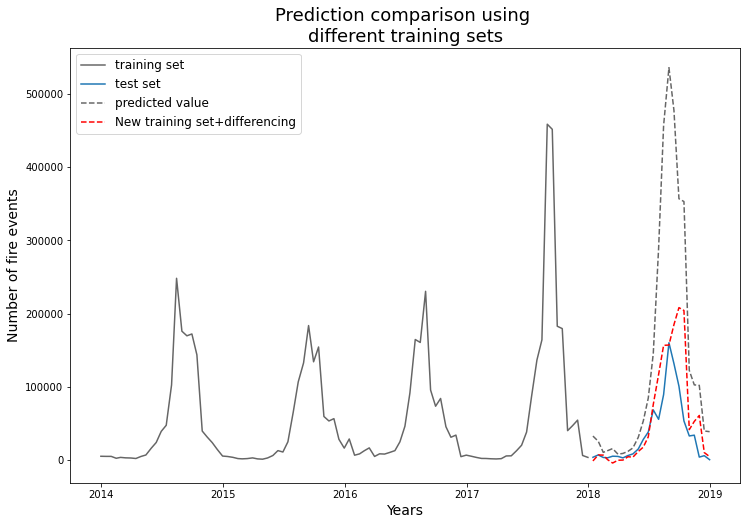

In [158]:
new_order = (3, 0, (1, 0, 1))
new_sorder =  (3, 1, 1, 24)

new_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo,
                                  order = new_order,
                                  seasonal_order = new_sorder,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

new_model_fit_ac = new_model_ac.fit() #res

new_predictions_ac = new_model_fit_ac.get_forecast(len(y_test)) #fcast1


##############################################################################

#(1, 0, 3) (1, 0, 2, 24)
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6)
ax.plot(y_test.riscofogo, label = 'test set')

ax.plot(predictions, label = 'predicted value', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(new_predictions_ac.predicted_mean, label = 'New training set+differencing', linestyle = '--', color = 'red')


#ax.fill_between(new_predictions_ac.summary_frame(alpha=0.10).index,
#                lower,
#                upper,
#                color = 'k', alpha = 0.2)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)

plt.legend(fontsize = 12)
plt.show()

In [159]:
#new_rfo_predictions, 1month window

residuals = predictions - y_test.riscofogo
residuals_new = new_predictions_ac.predicted_mean - y_test.riscofogo

MAE = np.mean(abs(residuals/y_test.riscofogo))
MAE_new = np.mean(abs(residuals_new/y_test.riscofogo))

print ('Mean absolute error: {}'.format(round(MAE, 2)))
print ('Mean absolute error: {}'.format(round(MAE_new, 2)))

Mean absolute error: 8.98
Mean absolute error: 1.9


In [160]:
rmse = np.sqrt(mean_squared_error(new_predictions_ac.predicted_mean, y_test))


print(rmse)
print(y_test.riscofogo.mean())

45462.05068815312
35812.791666666664


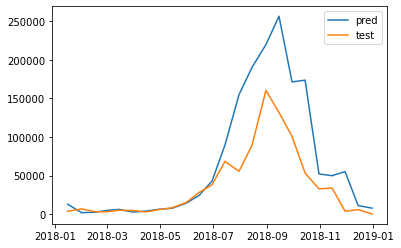

In [147]:
fig, ax = plt.subplots()

ax.plot(new_predictions_ac.predicted_mean, label = 'pred')
ax.plot(y_test, label = 'test')

plt.legend()
plt.show()